# Developing a unified representation of Alzheimer’s subtypes

# Part 1: Data Processing

This part will present the methodology used to process and prepare the data for the clustering through the SuStaIn algorithm.

The data will be harvested from the ADNI Merge dataset, which contains all relevant data of patients included in the clinical data collection. This includes genetic and environmental aspects, volumetric and manipulated data quantified from different imaging modalities and visit data iformation. The data has been modified from cotical areas to lobular data, to better resemble previous work done in the field and allow comparison of the results accordingly.

For the purposes of this research we will extract 5 subsets of data from this file: 
1. Train set for MRI ATROPHY - All baseline visits for patients that have had a Brain MRI assessing Atrophy.
2. Train set for PET AMYLOID BETA - All baseline visits for patients that have had a Brain PET assessing Amyloid Beta.
3. Train set for PET TAU - All baseline visits for patients that have had a Brain PET assessing Tau.
4. Test set - Unique set of patients with all three imaging modality data to help assess the models capacity for placing subjects in the same subtypes at a certain time point.
5. Test set - Longitudinal data set of patients with multiple MRI visits to help assess the models prediction abilities with real trajectories.
6. Test set - Longitudinal data set of patients with multiple PET AMYLOID BETA visits to help assess the models prediction abilities with real trajectories.
7. Test set - Longitudinal data set of patients with multiple PET TAU visits to help assess the models prediction abilities with real trajectories.

The file will be filtered by using the appropriate columns of data for each modality, and the patients must contain a diagnosis of some sort. 

Data limitations - There are some missing VISCODE/VISCODE2 values for the more recent PET scans. This loses approximately 900 amyloid PET scans, and approxiamtely 60 tau PET scans, which makes the dataset relatively smaller. 

    Import relevant packages for data analysis:

In [1]:
# import the python packages needed
import numpy as np
from pathlib import Path
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
import sys
import IPython
IPython.display.clear_output()
import matplotlib.pyplot as plt
from collections import Counter
# Ensure plots display in Jupyter Notebook
%matplotlib inline  
!pip install openpyxl


    Import the data:

In [2]:
# Point to the adnimerge CSV
csv_pth = Path.cwd().resolve() # assumes that the adnimerge CSV is in the current directory
# Load the data into a pandas DataFrame
df_merge2025 = pd.read_csv(csv_pth / "adnimerge2025_01Mar2025.csv", low_memory=False)
df_merge2025 = df_merge2025.copy(deep=True)


## Data Cleaning:
Before separating the data into groups per train/test, several data manipulations must be done in order to filter the relevant data only. 

Firstly, I need to add the relevant columns for analysis - we will be assessing data from MTL, frontal, occipital, temporal and parietal lobe stratification, alongside the asymmetry measures to understand if there is a difference between left and right progression. All these columns will be calculated and added to the data. For the PET scans I used the SUVR instead of the volume measures used for the atrophy measurement. 

SUVR - Standardised Uptake Value Ratio, is a quantative measure used in PET imaging to assess the uptake of tracers that bind specificall to proteins. It is referenced to regions and allows normalisation of the signal and comparison between subjects.
SUVR in the larger cortical lobes were calculates as a volume-weighted sum of SUVR in the sub-lobe regions.

Afterwards, NaN values for the required data will be filtered out of the data frame and relevant string values - gender data - transformed into non-quantitive values. 


## Lobe mapping:
Lobes stratification per Jake Vogel et. al (2004). 

### Frontal

Caudal Anterior Cingulate, Caudal Middle Frontal, Lateral Orbitofrontal, Medial Orbitofrontal, Pars Opercularis, Pars Orbitalis, Pars Triangularis, Precentral, Rostral Anterior Cingulate, Rostral Middle Frontal, Superior Frontal, Insula.

### Parietal

Isthmus Cingulate, Inferior Parietal, Precuneus, Superior Parietal, Supramarginal, Posterior Cingulate, Postcentral.

### Temporal

Parahippocampal, Inferior Temporal, Fusiform, Middle Temporal, Superior Temporal, Transverse Temporal.

### Occipital

Lateral Occipital, Lingual, Pericalcarine, Cuneus.

### MTL 

Entorhinal, Hippocampus, Amygdala.

### Asymmetry measures

We assess asymmetry individually because we want to use less biomarkers with sustain to simplify the data introduced to the model. In order to do this the left and right measures of each region must be merged. That could reduce the complexity of asymmetrical progression patterns that might be important when looking to determine subtypes. For this reason the asymmetry measure will help to capture these shifts per hemisphere for each modality, and the measure will be given to the sustain algorithm when it will subtype the data. SuStaIn receives positive values only and so we need 2 features of asymmetry to include bias for each side. 


Asymmetry Measure Left(per modality) = (All Left-side cortical volumes - All Right-side cortical volumes)/(All Left-side cortical volumes + All Right-side cortical volumes)

Asymmetry Measure Right(per modality) = (All Right-side cortical volumes - All Left-side cortical volumes)/(All Left-side cortical volumes + All Right-side cortical volumes)




In [3]:
# Define key columns and Column indicators for results of different modalities
rid = "RID"
dat = "EXAMDATE"
df_merge2025[dat] = pd.to_datetime(df_merge2025[dat])
dx = "DIAGNOSIS_STRING"
required = [rid,dat,dx]

diagnosis_num = "DIAGNOSIS" 
mmse_score = "MMSCORE" #memory scores - lower indicate more impairment
apoe4 = "APOE4" #presence of the gene APOE4
educ = "PTEDUCAT" #years of education
gender = "PTGENDER" #Gender- Male=1, Female=2
y_startadsym = "PTADBEG" #year of onset of AD symptoms
headsize_mri = "ICV_CorticalVolume" #overall headsize

# Select all columns containing "Left" or "Right" and either "CorticalVolume" or "SubcorticalVolume" for total ICV
volume_cols = [col for col in df_merge2025.columns if (("Left" in col or "Right" in col) and ("CorticalVolume" in col or "SubcorticalVolume" in col))]
df_merge2025["Total_BrainVolume"] = df_merge2025[volume_cols].sum(axis=1, skipna=True) # Sum across those columns row-wise
total_vol = "Total_BrainVolume" 


#Creation of Age column
y_of_birth = "PTDOBYY"
age = "Age"
df_merge2025 = df_merge2025[df_merge2025[y_of_birth].notna()]
df_merge2025[age] = 2025 - pd.to_numeric(df_merge2025[y_of_birth], errors="coerce")
df_merge2025.loc[:, age] = 2025 - df_merge2025[y_of_birth]
df_merge2025[age] = df_merge2025[age].astype(int)
df_merge2025 = df_merge2025.dropna(subset=[age])
df_merge2025.reset_index(drop=True, inplace=True) 

#Age of retirement column
retire_age = "AGE_RETIRE"
retirement = "PTNOTRT" #retired = 1, not retired = 0
y_retirement = "PTRTYR" #year of retirement
df_merge2025[retire_age] = df_merge2025[y_retirement] - df_merge2025[y_of_birth]


categories = [diagnosis_num, age, mmse_score, apoe4, educ, gender, retire_age]
categories_mri = [diagnosis_num, age, mmse_score, apoe4, educ, gender, retire_age, headsize_mri]


ab_ind = "LEFT_HIPPOCAMPUS_SUVR_amy"
tau_ind = "LEFT_HIPPOCAMPUS_SUVR_tau"
atro_ind = "LeftHippocampus_SubcorticalVolume"
indicators = [ab_ind, tau_ind, atro_ind]


In [4]:
#MRI LOBES

left_frontal_lobe_mri = [
    'LeftCaudalAnteriorCingulate_CorticalVolume',
    'LeftCaudalMiddleFrontal_CorticalVolume',
    'LeftLateralOrbitofrontal_CorticalVolume',
    'LeftMedialOrbitofrontal_CorticalVolume',
    'LeftParsOpercularis_CorticalVolume',
    'LeftParsOrbitalis_CorticalVolume',
    'LeftParsTriangularis_CorticalVolume',
    'LeftPrecentral_CorticalVolume',
    'LeftRostralAnteriorCingulate_CorticalVolume',
    'LeftRostralMiddleFrontal_CorticalVolume',
    'LeftSuperiorFrontal_CorticalVolume',
    'LeftInsula_CorticalVolume',
]

right_frontal_lobe_mri = [v.replace("Left","Right") for v in left_frontal_lobe_mri]
frontal_lobe_mri = left_frontal_lobe_mri + right_frontal_lobe_mri

left_occipital_lobe_mri = [
    'LeftLateralOccipital_CorticalVolume',
    'LeftLingual_CorticalVolume',
    'LeftPericalcarine_CorticalVolume',
    'LeftCuneus_CorticalVolume',
]
    
right_occipital_lobe_mri = [v.replace("Left","Right") for v in left_occipital_lobe_mri]
occipital_lobe_mri = left_occipital_lobe_mri + right_occipital_lobe_mri

left_parietal_lobe_mri = [
    'LeftIsthmusCingulate_CorticalVolume',
    'LeftInferiorParietal_CorticalVolume',
    'LeftPrecuneus_CorticalVolume',
    'LeftSuperiorParietal_CorticalVolume',
    'LeftSupramarginal_CorticalVolume',
    'LeftPosteriorCingulate_CorticalVolume',
    'LeftPostcentral_CorticalVolume',
]
    
right_parietal_lobe_mri = [v.replace("Left","Right") for v in left_parietal_lobe_mri]
parietal_lobe_mri = left_parietal_lobe_mri + right_parietal_lobe_mri

left_temporal_lobe_mri = [
    'LeftParahippocampal_CorticalVolume',
    'LeftInferiorTemporal_CorticalVolume',
    'LeftFusiform_CorticalVolume',
    'LeftMiddleTemporal_CorticalVolume',
    'LeftSuperiorTemporal_CorticalVolume',
    'LeftTransverseTemporal_CorticalVolume',
]
    
right_temporal_lobe_mri = [v.replace("Left","Right") for v in left_temporal_lobe_mri]
temporal_lobe_mri = left_temporal_lobe_mri + right_temporal_lobe_mri

left_mtl_mri = [
    'LeftEntorhinal_CorticalVolume',
    'LeftHippocampus_SubcorticalVolume',
    'LeftAmygdala_SubcorticalVolume',
]
    
right_mtl_mri = [v.replace("Left","Right") for v in left_mtl_mri]
mtl_mri = left_mtl_mri + right_mtl_mri

new_columns_mri = {
    "Frontal_lobe_volume": df_merge2025[frontal_lobe_mri].sum(axis=1, skipna=True).round(3),
    "Occipital_lobe_volume": df_merge2025[occipital_lobe_mri].sum(axis=1, skipna=True).round(3),
    "Parietal_lobe_volume": df_merge2025[parietal_lobe_mri].sum(axis=1, skipna=True).round(3),
    "Temporal_lobe_volume": df_merge2025[temporal_lobe_mri].sum(axis=1, skipna=True).round(3),
    "MTL_volume": df_merge2025[mtl_mri].sum(axis=1, skipna=True).round(3),
}

# Concatenate all new columns at once to avoid fragmentation
df_merge2025 = pd.concat([df_merge2025, pd.DataFrame(new_columns_mri)], axis=1)



In [5]:
lobe_dict_ab = {
    'Frontal_lobe': {
        'suvr': ['CTX_LH_CAUDALANTERIORCINGULATE_SUVR_amy',
                 'CTX_LH_CAUDALMIDDLEFRONTAL_SUVR_amy',
                 'CTX_LH_LATERALORBITOFRONTAL_SUVR_amy',
                 'CTX_LH_MEDIALORBITOFRONTAL_SUVR_amy',
                 'CTX_LH_PARSOPERCULARIS_SUVR_amy',
                 'CTX_LH_PARSORBITALIS_SUVR_amy',
                 'CTX_LH_PARSTRIANGULARIS_SUVR_amy',
                 'CTX_LH_PRECENTRAL_SUVR_amy',
                 'CTX_LH_ROSTRALANTERIORCINGULATE_SUVR_amy',
                 'CTX_LH_ROSTRALMIDDLEFRONTAL_SUVR_amy',
                 'CTX_LH_SUPERIORFRONTAL_SUVR_amy',
                 'CTX_LH_INSULA_SUVR_amy',
                 'CTX_RH_CAUDALANTERIORCINGULATE_SUVR_amy',
                 'CTX_RH_CAUDALMIDDLEFRONTAL_SUVR_amy',
                 'CTX_RH_LATERALORBITOFRONTAL_SUVR_amy',
                 'CTX_RH_MEDIALORBITOFRONTAL_SUVR_amy',
                 'CTX_RH_PARSOPERCULARIS_SUVR_amy',
                 'CTX_RH_PARSORBITALIS_SUVR_amy',
                 'CTX_RH_PARSTRIANGULARIS_SUVR_amy',
                 'CTX_RH_PRECENTRAL_SUVR_amy',
                 'CTX_RH_ROSTRALANTERIORCINGULATE_SUVR_amy',
                 'CTX_RH_ROSTRALMIDDLEFRONTAL_SUVR_amy',
                 'CTX_RH_SUPERIORFRONTAL_SUVR_amy',
                 'CTX_RH_INSULA_SUVR_amy',
                ],
        'vol':  ['CTX_LH_CAUDALANTERIORCINGULATE_VOLUME_amy',
                 'CTX_LH_CAUDALMIDDLEFRONTAL_VOLUME_amy',
                 'CTX_LH_LATERALORBITOFRONTAL_VOLUME_amy',
                 'CTX_LH_MEDIALORBITOFRONTAL_VOLUME_amy',
                 'CTX_LH_PARSOPERCULARIS_VOLUME_amy',
                 'CTX_LH_PARSORBITALIS_VOLUME_amy',
                 'CTX_LH_PARSTRIANGULARIS_VOLUME_amy',
                 'CTX_LH_PRECENTRAL_VOLUME_amy',
                 'CTX_LH_ROSTRALANTERIORCINGULATE_VOLUME_amy',
                 'CTX_LH_ROSTRALMIDDLEFRONTAL_VOLUME_amy',
                 'CTX_LH_SUPERIORFRONTAL_VOLUME_amy',
                 'CTX_LH_INSULA_VOLUME_amy',
                 'CTX_RH_CAUDALANTERIORCINGULATE_VOLUME_amy',
                 'CTX_RH_CAUDALMIDDLEFRONTAL_VOLUME_amy',
                 'CTX_RH_LATERALORBITOFRONTAL_VOLUME_amy',
                 'CTX_RH_MEDIALORBITOFRONTAL_VOLUME_amy',
                 'CTX_RH_PARSOPERCULARIS_VOLUME_amy',
                 'CTX_RH_PARSORBITALIS_VOLUME_amy',
                 'CTX_RH_PARSTRIANGULARIS_VOLUME_amy',
                 'CTX_RH_PRECENTRAL_VOLUME_amy',
                 'CTX_RH_ROSTRALANTERIORCINGULATE_VOLUME_amy',
                 'CTX_RH_ROSTRALMIDDLEFRONTAL_VOLUME_amy',
                 'CTX_RH_SUPERIORFRONTAL_VOLUME_amy',
                 'CTX_RH_INSULA_VOLUME_amy',
                ],
    },
    'Occipital_lobe': {
        'suvr': ['CTX_LH_LATERALOCCIPITAL_SUVR_amy',
                 'CTX_LH_LINGUAL_SUVR_amy',
                 'CTX_LH_PERICALCARINE_SUVR_amy',
                 'CTX_LH_CUNEUS_SUVR_amy',
                 'CTX_RH_LATERALOCCIPITAL_SUVR_amy',
                 'CTX_RH_LINGUAL_SUVR_amy',
                 'CTX_RH_PERICALCARINE_SUVR_amy',
                 'CTX_RH_CUNEUS_SUVR_amy',
                ],
        'vol':  ['CTX_LH_LATERALOCCIPITAL_VOLUME_amy',
                 'CTX_LH_LINGUAL_VOLUME_amy',
                 'CTX_LH_PERICALCARINE_VOLUME_amy',
                 'CTX_LH_CUNEUS_VOLUME_amy',
                 'CTX_RH_LATERALOCCIPITAL_VOLUME_amy',
                 'CTX_RH_LINGUAL_VOLUME_amy',
                 'CTX_RH_PERICALCARINE_VOLUME_amy',
                 'CTX_RH_CUNEUS_VOLUME_amy',
                ]
    },
    'Parietal_lobe': {
        'suvr': ['CTX_LH_ISTHMUSCINGULATE_SUVR_amy',
                 'CTX_LH_INFERIORPARIETAL_SUVR_amy',
                 'CTX_LH_PRECUNEUS_SUVR_amy',
                 'CTX_LH_SUPERIORPARIETAL_SUVR_amy',
                 'CTX_LH_SUPRAMARGINAL_SUVR_amy',
                 'CTX_LH_POSTERIORCINGULATE_SUVR_amy',
                 'CTX_LH_POSTCENTRAL_SUVR_amy',
                 'CTX_RH_ISTHMUSCINGULATE_SUVR_amy',
                 'CTX_RH_INFERIORPARIETAL_SUVR_amy',
                 'CTX_RH_PRECUNEUS_SUVR_amy',
                 'CTX_RH_SUPERIORPARIETAL_SUVR_amy',
                 'CTX_RH_SUPRAMARGINAL_SUVR_amy',
                 'CTX_RH_POSTERIORCINGULATE_SUVR_amy',
                 'CTX_RH_POSTCENTRAL_SUVR_amy',
                ],
        'vol':  ['CTX_LH_ISTHMUSCINGULATE_VOLUME_amy',
                 'CTX_LH_INFERIORPARIETAL_VOLUME_amy',
                 'CTX_LH_PRECUNEUS_VOLUME_amy',
                 'CTX_LH_SUPERIORPARIETAL_VOLUME_amy',
                 'CTX_LH_SUPRAMARGINAL_VOLUME_amy',
                 'CTX_LH_POSTERIORCINGULATE_VOLUME_amy',
                 'CTX_LH_POSTCENTRAL_VOLUME_amy',
                 'CTX_RH_ISTHMUSCINGULATE_VOLUME_amy',
                 'CTX_RH_INFERIORPARIETAL_VOLUME_amy',
                 'CTX_RH_PRECUNEUS_VOLUME_amy',
                 'CTX_RH_SUPERIORPARIETAL_VOLUME_amy',
                 'CTX_RH_SUPRAMARGINAL_VOLUME_amy',
                 'CTX_RH_POSTERIORCINGULATE_VOLUME_amy',
                 'CTX_RH_POSTCENTRAL_VOLUME_amy',
                ]
    },'Temporal_lobe': {
        'suvr': ['CTX_LH_PARAHIPPOCAMPAL_SUVR_amy',
                 'CTX_LH_INFERIORTEMPORAL_SUVR_amy',
                 'CTX_LH_FUSIFORM_SUVR_amy',
                 'CTX_LH_MIDDLETEMPORAL_SUVR_amy',
                 'CTX_LH_SUPERIORTEMPORAL_SUVR_amy',
                 'CTX_LH_TRANSVERSETEMPORAL_SUVR_amy',
                 'CTX_RH_PARAHIPPOCAMPAL_SUVR_amy',
                 'CTX_RH_INFERIORTEMPORAL_SUVR_amy',
                 'CTX_RH_FUSIFORM_SUVR_amy',
                 'CTX_RH_MIDDLETEMPORAL_SUVR_amy',
                 'CTX_RH_SUPERIORTEMPORAL_SUVR_amy',
                 'CTX_RH_TRANSVERSETEMPORAL_SUVR_amy',
                ], 
        'vol':  ['CTX_LH_PARAHIPPOCAMPAL_VOLUME_amy',
                 'CTX_LH_INFERIORTEMPORAL_VOLUME_amy',
                 'CTX_LH_FUSIFORM_VOLUME_amy',
                 'CTX_LH_MIDDLETEMPORAL_VOLUME_amy',
                 'CTX_LH_SUPERIORTEMPORAL_VOLUME_amy',
                 'CTX_LH_TRANSVERSETEMPORAL_VOLUME_amy',
                 'CTX_RH_PARAHIPPOCAMPAL_VOLUME_amy',
                 'CTX_RH_INFERIORTEMPORAL_VOLUME_amy',
                 'CTX_RH_FUSIFORM_VOLUME_amy',
                 'CTX_RH_MIDDLETEMPORAL_VOLUME_amy',
                 'CTX_RH_SUPERIORTEMPORAL_VOLUME_amy',
                 'CTX_RH_TRANSVERSETEMPORAL_VOLUME_amy',
                ]
    },'MTL': {
        'suvr': ['CTX_LH_ENTORHINAL_SUVR_amy',
                 'LEFT_HIPPOCAMPUS_SUVR_amy',
                 'LEFT_AMYGDALA_SUVR_amy',
                 'CTX_RH_ENTORHINAL_SUVR_amy',
                 'RIGHT_HIPPOCAMPUS_SUVR_amy',
                 'RIGHT_AMYGDALA_SUVR_amy',
                ],
        'vol':  ['CTX_LH_ENTORHINAL_VOLUME_amy',
                 'LEFT_HIPPOCAMPUS_VOLUME_amy',
                 'LEFT_AMYGDALA_VOLUME_amy',
                 'CTX_RH_ENTORHINAL_VOLUME_amy',
                 'RIGHT_HIPPOCAMPUS_VOLUME_amy',
                 'RIGHT_AMYGDALA_VOLUME_amy',
                ]
    },
}

for lobe, cols in lobe_dict_ab.items():
    suvr_data = df_merge2025[cols['suvr']].values
    vol_data = df_merge2025[cols['vol']].values
    numerator = (suvr_data * vol_data).sum(axis=1)
    denominator = vol_data.sum(axis=1)
    df_merge2025[f"{lobe}_SUVR_weighted_ab"] = numerator / denominator



In [6]:
#TAU LOBES

lobe_dict_tau = {
    'Frontal_lobe': {
        'suvr': ['CTX_LH_CAUDALANTERIORCINGULATE_SUVR_tau',
                 'CTX_LH_CAUDALMIDDLEFRONTAL_SUVR_tau',
                 'CTX_LH_LATERALORBITOFRONTAL_SUVR_tau',
                 'CTX_LH_MEDIALORBITOFRONTAL_SUVR_tau',
                 'CTX_LH_PARSOPERCULARIS_SUVR_tau',
                 'CTX_LH_PARSORBITALIS_SUVR_tau',
                 'CTX_LH_PARSTRIANGULARIS_SUVR_tau',
                 'CTX_LH_PRECENTRAL_SUVR_tau',
                 'CTX_LH_ROSTRALANTERIORCINGULATE_SUVR_tau',
                 'CTX_LH_ROSTRALMIDDLEFRONTAL_SUVR_tau',
                 'CTX_LH_SUPERIORFRONTAL_SUVR_tau',
                 'CTX_LH_INSULA_SUVR_tau',
                 'CTX_RH_CAUDALANTERIORCINGULATE_SUVR_tau',
                 'CTX_RH_CAUDALMIDDLEFRONTAL_SUVR_tau',
                 'CTX_RH_LATERALORBITOFRONTAL_SUVR_tau',
                 'CTX_RH_MEDIALORBITOFRONTAL_SUVR_tau',
                 'CTX_RH_PARSOPERCULARIS_SUVR_tau',
                 'CTX_RH_PARSORBITALIS_SUVR_tau',
                 'CTX_RH_PARSTRIANGULARIS_SUVR_tau',
                 'CTX_RH_PRECENTRAL_SUVR_tau',
                 'CTX_RH_ROSTRALANTERIORCINGULATE_SUVR_tau',
                 'CTX_RH_ROSTRALMIDDLEFRONTAL_SUVR_tau',
                 'CTX_RH_SUPERIORFRONTAL_SUVR_tau',
                 'CTX_RH_INSULA_SUVR_tau',
                ],
        'vol':  ['CTX_LH_CAUDALANTERIORCINGULATE_VOLUME_tau',
                 'CTX_LH_CAUDALMIDDLEFRONTAL_VOLUME_tau',
                 'CTX_LH_LATERALORBITOFRONTAL_VOLUME_tau',
                 'CTX_LH_MEDIALORBITOFRONTAL_VOLUME_tau',
                 'CTX_LH_PARSOPERCULARIS_VOLUME_tau',
                 'CTX_LH_PARSORBITALIS_VOLUME_tau',
                 'CTX_LH_PARSTRIANGULARIS_VOLUME_tau',
                 'CTX_LH_PRECENTRAL_VOLUME_tau',
                 'CTX_LH_ROSTRALANTERIORCINGULATE_VOLUME_tau',
                 'CTX_LH_ROSTRALMIDDLEFRONTAL_VOLUME_tau',
                 'CTX_LH_SUPERIORFRONTAL_VOLUME_tau',
                 'CTX_LH_INSULA_VOLUME_tau',
                 'CTX_RH_CAUDALANTERIORCINGULATE_VOLUME_tau',
                 'CTX_RH_CAUDALMIDDLEFRONTAL_VOLUME_tau',
                 'CTX_RH_LATERALORBITOFRONTAL_VOLUME_tau',
                 'CTX_RH_MEDIALORBITOFRONTAL_VOLUME_tau',
                 'CTX_RH_PARSOPERCULARIS_VOLUME_tau',
                 'CTX_RH_PARSORBITALIS_VOLUME_tau',
                 'CTX_RH_PARSTRIANGULARIS_VOLUME_tau',
                 'CTX_RH_PRECENTRAL_VOLUME_tau',
                 'CTX_RH_ROSTRALANTERIORCINGULATE_VOLUME_tau',
                 'CTX_RH_ROSTRALMIDDLEFRONTAL_VOLUME_tau',
                 'CTX_RH_SUPERIORFRONTAL_VOLUME_tau',
                 'CTX_RH_INSULA_VOLUME_tau',
                ],
    },
    'Occipital_lobe': {
        'suvr': ['CTX_LH_LATERALOCCIPITAL_SUVR_tau',
                 'CTX_LH_LINGUAL_SUVR_tau',
                 'CTX_LH_PERICALCARINE_SUVR_tau',
                 'CTX_LH_CUNEUS_SUVR_tau',
                 'CTX_RH_LATERALOCCIPITAL_SUVR_tau',
                 'CTX_RH_LINGUAL_SUVR_tau',
                 'CTX_RH_PERICALCARINE_SUVR_tau',
                 'CTX_RH_CUNEUS_SUVR_tau',
                ],
        'vol':  ['CTX_LH_LATERALOCCIPITAL_VOLUME_tau',
                 'CTX_LH_LINGUAL_VOLUME_tau',
                 'CTX_LH_PERICALCARINE_VOLUME_tau',
                 'CTX_LH_CUNEUS_VOLUME_tau',
                 'CTX_RH_LATERALOCCIPITAL_VOLUME_tau',
                 'CTX_RH_LINGUAL_VOLUME_tau',
                 'CTX_RH_PERICALCARINE_VOLUME_tau',
                 'CTX_RH_CUNEUS_VOLUME_tau',
                ]
    },
    'Parietal_lobe': {
        'suvr': ['CTX_LH_ISTHMUSCINGULATE_SUVR_tau',
                 'CTX_LH_INFERIORPARIETAL_SUVR_tau',
                 'CTX_LH_PRECUNEUS_SUVR_tau',
                 'CTX_LH_SUPERIORPARIETAL_SUVR_tau',
                 'CTX_LH_SUPRAMARGINAL_SUVR_tau',
                 'CTX_LH_POSTERIORCINGULATE_SUVR_tau',
                 'CTX_LH_POSTCENTRAL_SUVR_tau',
                 'CTX_RH_ISTHMUSCINGULATE_SUVR_tau',
                 'CTX_RH_INFERIORPARIETAL_SUVR_tau',
                 'CTX_RH_PRECUNEUS_SUVR_tau',
                 'CTX_RH_SUPERIORPARIETAL_SUVR_tau',
                 'CTX_RH_SUPRAMARGINAL_SUVR_tau',
                 'CTX_RH_POSTERIORCINGULATE_SUVR_tau',
                 'CTX_RH_POSTCENTRAL_SUVR_tau',
                ],
        'vol':  ['CTX_LH_ISTHMUSCINGULATE_VOLUME_tau',
                 'CTX_LH_INFERIORPARIETAL_VOLUME_tau',
                 'CTX_LH_PRECUNEUS_VOLUME_tau',
                 'CTX_LH_SUPERIORPARIETAL_VOLUME_tau',
                 'CTX_LH_SUPRAMARGINAL_VOLUME_tau',
                 'CTX_LH_POSTERIORCINGULATE_VOLUME_tau',
                 'CTX_LH_POSTCENTRAL_VOLUME_tau',
                 'CTX_RH_ISTHMUSCINGULATE_VOLUME_tau',
                 'CTX_RH_INFERIORPARIETAL_VOLUME_tau',
                 'CTX_RH_PRECUNEUS_VOLUME_tau',
                 'CTX_RH_SUPERIORPARIETAL_VOLUME_tau',
                 'CTX_RH_SUPRAMARGINAL_VOLUME_tau',
                 'CTX_RH_POSTERIORCINGULATE_VOLUME_tau',
                 'CTX_RH_POSTCENTRAL_VOLUME_tau',
                ]
    },
    'Temporal_lobe': {
        'suvr': ['CTX_LH_PARAHIPPOCAMPAL_SUVR_tau',
                 'CTX_LH_INFERIORTEMPORAL_SUVR_tau',
                 'CTX_LH_FUSIFORM_SUVR_tau',
                 'CTX_LH_MIDDLETEMPORAL_SUVR_tau',
                 'CTX_LH_SUPERIORTEMPORAL_SUVR_tau',
                 'CTX_LH_TRANSVERSETEMPORAL_SUVR_tau',
                 'CTX_RH_PARAHIPPOCAMPAL_SUVR_tau',
                 'CTX_RH_INFERIORTEMPORAL_SUVR_tau',
                 'CTX_RH_FUSIFORM_SUVR_tau',
                 'CTX_RH_MIDDLETEMPORAL_SUVR_tau',
                 'CTX_RH_SUPERIORTEMPORAL_SUVR_tau',
                 'CTX_RH_TRANSVERSETEMPORAL_SUVR_tau',
                ],
        'vol':  ['CTX_LH_PARAHIPPOCAMPAL_VOLUME_tau',
                 'CTX_LH_INFERIORTEMPORAL_VOLUME_tau',
                 'CTX_LH_FUSIFORM_VOLUME_tau',
                 'CTX_LH_MIDDLETEMPORAL_VOLUME_tau',
                 'CTX_LH_SUPERIORTEMPORAL_VOLUME_tau',
                 'CTX_LH_TRANSVERSETEMPORAL_VOLUME_tau',
                 'CTX_RH_PARAHIPPOCAMPAL_VOLUME_tau',
                 'CTX_RH_INFERIORTEMPORAL_VOLUME_tau',
                 'CTX_RH_FUSIFORM_VOLUME_tau',
                 'CTX_RH_MIDDLETEMPORAL_VOLUME_tau',
                 'CTX_RH_SUPERIORTEMPORAL_VOLUME_tau',
                 'CTX_RH_TRANSVERSETEMPORAL_VOLUME_tau',
                ]
    },
    'MTL': {
        'suvr': ['CTX_LH_ENTORHINAL_SUVR_tau',
                 'LEFT_HIPPOCAMPUS_SUVR_tau',
                 'LEFT_AMYGDALA_SUVR_tau',
                 'CTX_RH_ENTORHINAL_SUVR_tau',
                 'RIGHT_HIPPOCAMPUS_SUVR_tau',
                 'RIGHT_AMYGDALA_SUVR_tau',
                ],
        'vol':  ['CTX_LH_ENTORHINAL_VOLUME_tau',
                 'LEFT_HIPPOCAMPUS_VOLUME_tau',
                 'LEFT_AMYGDALA_VOLUME_tau',
                 'CTX_RH_ENTORHINAL_VOLUME_tau',
                 'RIGHT_HIPPOCAMPUS_VOLUME_tau',
                 'RIGHT_AMYGDALA_VOLUME_tau',
                ]
    },
}

for lobe, cols in lobe_dict_tau.items():
    suvr_data = df_merge2025[cols['suvr']].values
    vol_data = df_merge2025[cols['vol']].values
    numerator = (suvr_data * vol_data).sum(axis=1)
    denominator = vol_data.sum(axis=1)
    df_merge2025[f"{lobe}_SUVR_weighted_tau"] = numerator / denominator



In [7]:
# --- Define lobes
lobes = ['Frontal_lobe', 'Occipital_lobe', 'Parietal_lobe', 'Temporal_lobe', 'MTL']

# --- MRI Volumetric Lobe Asymmetry
for lobe in lobes:
    left_cols = [c for c in eval(f'left_{lobe.lower()}_mri')]
    right_cols = [c for c in eval(f'right_{lobe.lower()}_mri')]
    
    left_vol = df_merge2025[left_cols].sum(axis=1)
    right_vol = df_merge2025[right_cols].sum(axis=1)
    
    df_merge2025[f'{lobe}_Asymmetry_MRI_L'] = ((left_vol - right_vol) / (left_vol + right_vol)).round(4)
    df_merge2025[f'{lobe}_Asymmetry_MRI_R'] = ((right_vol - left_vol) / (left_vol + right_vol)).round(4)

# --- Amyloid-PET Weighted SUVR Lobe Asymmetry
for lobe in lobes:
    ab_l_suvr = [c for c in lobe_dict_ab[lobe]['suvr'] if 'LH' in c or 'LEFT' in c]
    ab_r_suvr = [c for c in lobe_dict_ab[lobe]['suvr'] if 'RH' in c or 'RIGHT' in c]
    ab_l_vol = [c for c in lobe_dict_ab[lobe]['vol'] if 'LH' in c or 'LEFT' in c]
    ab_r_vol = [c for c in lobe_dict_ab[lobe]['vol'] if 'RH' in c or 'RIGHT' in c]

    ab_left = (df_merge2025[ab_l_suvr].values * df_merge2025[ab_l_vol].values).sum(axis=1) / df_merge2025[ab_l_vol].sum(axis=1)
    ab_right = (df_merge2025[ab_r_suvr].values * df_merge2025[ab_r_vol].values).sum(axis=1) / df_merge2025[ab_r_vol].sum(axis=1)

    df_merge2025[f'{lobe}_Asymmetry_ab_L'] = ((ab_left - ab_right) / (ab_left + ab_right)).round(4)
    df_merge2025[f'{lobe}_Asymmetry_ab_R'] = ((ab_right - ab_left) / (ab_left + ab_right)).round(4)

# --- Tau-PET Weighted SUVR Lobe Asymmetry
for lobe in lobes:
    tau_l_suvr = [c for c in lobe_dict_tau[lobe]['suvr'] if 'LH' in c or 'LEFT' in c]
    tau_r_suvr = [c for c in lobe_dict_tau[lobe]['suvr'] if 'RH' in c or 'RIGHT' in c]
    tau_l_vol = [c for c in lobe_dict_tau[lobe]['vol'] if 'LH' in c or 'LEFT' in c]
    tau_r_vol = [c for c in lobe_dict_tau[lobe]['vol'] if 'RH' in c or 'RIGHT' in c]
    
    tau_left = (df_merge2025[tau_l_suvr].values * df_merge2025[tau_l_vol].values).sum(axis=1) / df_merge2025[tau_l_vol].sum(axis=1)
    tau_right = (df_merge2025[tau_r_suvr].values * df_merge2025[tau_r_vol].values).sum(axis=1) / df_merge2025[tau_r_vol].sum(axis=1)
    
    df_merge2025[f'{lobe}_Asymmetry_tau_L'] = ((tau_left - tau_right) / (tau_left + tau_right)).round(4)
    df_merge2025[f'{lobe}_Asymmetry_tau_R'] = ((tau_right - tau_left) / (tau_left + tau_right)).round(4)



## Filtering the subsets:

In [8]:
# Filter for one time visits (train 1-3 + test 4) per indicator

df_merge2025 = df_merge2025.dropna(subset=[dx])

# Data from any of the modalities - Full Dataset 
first_visit_some = df_merge2025[(df_merge2025[ab_ind].notnull()) | (df_merge2025[tau_ind].notnull()) | (df_merge2025[atro_ind].notnull())]
first_visit_some = first_visit_some.sort_values([rid, dat], ascending=[True, True])
num_some_modalities = (first_visit_some[rid].nunique())
print(f"There are {num_some_modalities} subjects with data in at least one of the three imaging techniques. \n")

# Multimodal Test set - All 3 modalities - 4 
test_multimodal = first_visit_some[(df_merge2025[ab_ind].notnull()) & (df_merge2025[tau_ind].notnull()) & (df_merge2025[atro_ind].notnull())]
test_multimodal = test_multimodal.sort_values([rid, dat], ascending=[True, True])
test_multimodal = test_multimodal.drop_duplicates(subset=rid)
test_multimodal = test_multimodal[test_multimodal["TRACER_amy"] == "FBP"]
test_multimodal = test_multimodal[test_multimodal["TRACER_tau"] == "FTP"]
num_test_multimodal = (test_multimodal[rid].nunique())
print(f"There are {num_test_multimodal} subjects with data in all three imaging techniques. \n---> This is the relevant TEST SET FOR MULTIMODAL data. \n")
test_multimodal = test_multimodal.copy(deep=True).reset_index()

# Full Train set - without the multimodal test set (train 1-3)
train_multimodal = first_visit_some[~first_visit_some[rid].isin(test_multimodal[rid])]
num_train = (train_multimodal[rid].nunique())
print(f"There are {num_train} subjects in the train only data subset - in at least one of the three imaging techniques, but not all three of them. \n---> This is the relevant pool for TRAIN SET data. \n")

# Filter for longitudinal data test sets
# Step 1: Identify Subjects with Longitudinal Data (Multiple Visits)
multi_visit_rids = df_merge2025.duplicated(subset=[rid], keep=False)
longitudinal_rid_list = df_merge2025.loc[multi_visit_rids, rid].unique().copy()
# Step 2: Filter by Imaging Modality, make sure there are several visits within the data for the modality and count unique subjects will happen separately in each individual modality




There are 2013 subjects with data in at least one of the three imaging techniques. 

There are 305 subjects with data in all three imaging techniques. 
---> This is the relevant TEST SET FOR MULTIMODAL data. 

There are 1708 subjects in the train only data subset - in at least one of the three imaging techniques, but not all three of them. 
---> This is the relevant pool for TRAIN SET data. 



/var/folders/nl/7qp9kcyn5c965d6fjctkjyd00000gn/T/ipykernel_33875/372319993.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  test_multimodal = first_visit_some[(df_merge2025[ab_ind].notnull()) & (df_merge2025[tau_ind].notnull()) & (df_merge2025[atro_ind].notnull())]


## Atrophy MRI Data - Preparation:

I start by creating the longitudinal dataset - Here I search for RIDs with data over several exam dates with MRI data for each visit. 

In [9]:
#create the subset of potential train data with data for MRI volume
mri_trainset  = train_multimodal.dropna(subset=[atro_ind]) # may include duplicates
mri_trainset = mri_trainset.sort_values([rid, dat])   # Sort by RID and exam date
mri_trainset = mri_trainset.copy(deep=True)

# Filter for MRI longitudinal data test set
## Test set 5 - MRI Longitudinal Test Set
test_longitudinal_mri = df_merge2025[
    (df_merge2025[rid].isin(mri_trainset[rid])) &  # RID is in train set
    (df_merge2025[rid].isin(longitudinal_rid_list)) &  # RID has multiple visits
    (df_merge2025[atro_ind].notnull())  # MRI data is present on all visits
].sort_values([rid, dat]).reset_index()
list_longitudinal_mri = test_longitudinal_mri.duplicated(subset=[rid], keep=False) #Find all rows where the RID occurs more than once in dataset 
list_longitudinal_mri = test_longitudinal_mri.loc[list_longitudinal_mri, rid].unique().copy() #Extract the unique RIDs of those subjects who have multiple visits after filtering.
test_longitudinal_mri = test_longitudinal_mri[(test_longitudinal_mri[rid].isin(list_longitudinal_mri))].sort_values([rid, dat]).reset_index() #Keep only rows where RID is in list.
num_test_longitudinal_mri = test_longitudinal_mri[rid].nunique()

num_train_atro = (mri_trainset[rid].nunique())
print(f"First filtered Train set MRI : The number of subjects with MRI visits (and possibly one more scan type) is {num_train_atro}.\n")
print(f"Longitudinal Test set MRI : There are {len(test_longitudinal_mri)} entries in the of longitudinal MRI test set.\nThere are {num_test_longitudinal_mri} subjects in this data set.\n")



First filtered Train set MRI : The number of subjects with MRI visits (and possibly one more scan type) is 1506.

Longitudinal Test set MRI : There are 2602 entries in the of longitudinal MRI test set.
There are 914 subjects in this data set.



Next I do some cleaning on the rest of the MRI data. The later exam dates for the subjects should be removed from the MRI train dataset. I also wanted to make sure that the subjects that are initially diagnosed as CN stay that way over time and if not are removed from the train set as to not create a bias. From the remaining data I then remove outliers (age and gender).

In [10]:
#remove duplicates from the trainset (they appear in the longitudinal testset)
mri_trainset[dat] = pd.to_datetime(mri_trainset[dat]) # Ensure EXAMDATE is in datetime format
mri_trainset = mri_trainset.sort_values(by=[rid, dat])
mri_trainset = mri_trainset.drop_duplicates(subset=[rid], keep='first')  # Keep first occurrence per RID

# Testing to see that all CN stay CN over time (This is for only some of the CN in mri_trainset) 
test_longitudinal_mri[dat] = pd.to_datetime(test_longitudinal_mri[dat]) # Ensure EXAMDATE is in datetime format
test_longitudinal_mri = test_longitudinal_mri.sort_values(by=[rid, dat])

# Function to check if diagnosis changed from CN to a more severe condition
def check_diagnosis_change(group):
    unique_diagnoses = group[dx].unique() # Get unique diagnoses for the subject (RID)
    # If the subject has a diagnosis other than CN over time, mark as not really CN
    if 'CN' in unique_diagnoses:
        if any(dx not in ['CN'] for dx in unique_diagnoses):  # MCI or dementia
            return True
    return False

# Group by RID and apply the diagnosis check function
non_cn_rids_mri = test_longitudinal_mri.groupby(rid).filter(check_diagnosis_change)

# Get the unique RIDs of patients who are not really CN
unique_non_cn_rids_mri = non_cn_rids_mri[rid].unique()
num_unique_non_cn_rids_mri = len(unique_non_cn_rids_mri)
print(f"There are {num_unique_non_cn_rids_mri} out of {test_longitudinal_mri[rid].nunique()} subjects the Longitudinal MRI data that develop MCI/Dementia over time.\n")
mri_trainset = mri_trainset[~mri_trainset[rid].isin(unique_non_cn_rids_mri)]
print("These RIDs have been removed from the mri_trainset as they might bias the control population results.")

# Filter out subjects who are below 60 or above 104 years old
mri_trainset = mri_trainset[(mri_trainset[age] >= 60) & (mri_trainset[age] <= 104)]
print("\nComparison shows that there are 2 subjects under 60 y/o and 2 over 104 y/o - so these outliers have been removed from the dataset.\n")

# RID Female exclusion lists (subjects already present in other modalities)
list_common_ab_mri = [6049, 4482, 5158, 6088, 4028, 4269, 6415, 6224, 4496, 6524, 2201, 4348, 5213, 1016, 767]
list_common_tau_mri = [6786, 6436, 6572, 6385, 6164, 6422, 6266, 6367]
rids_to_exclude = set(list_common_ab_mri + list_common_tau_mri)

print(f"Number of female CN subjects in MRI and AB dataset: {len(list_common_ab_mri)}, these have been removed.")
print(f"Number of female CN subjects in MRI and TAU dataset: {len(list_common_tau_mri)}, these have been removed.\n")
mri_trainset = mri_trainset[~mri_trainset[rid].isin(rids_to_exclude)] # Remove all specified RIDs from mri_trainset


print("Additionally removing 90 randomly selected female CN subjects to reduce CN female bias.")
# Filter for CN females not in the exclusion lists
eligible_cn_females = mri_trainset[
    (mri_trainset[dx] == 'CN') &
    (mri_trainset[gender] == 2) & 
    (~mri_trainset[rid].isin(rids_to_exclude))
]

# Randomly sample 90 RIDs (without replacement)
if eligible_cn_females[rid].nunique() >= 90:
    random_90_rids = eligible_cn_females[rid].sample(n=90, random_state=42).tolist()
else:
    random_90_rids = eligible_cn_females[rid].tolist()

mri_trainset = mri_trainset[~mri_trainset[rid].isin(random_90_rids)]

# Final count
num_train_atro = (mri_trainset[rid].nunique())
print(f"\nTrain set MRI : The number of subjects with MRI visits (and possibly one more scan type) is {num_train_atro}.\n")



There are 78 out of 914 subjects the Longitudinal MRI data that develop MCI/Dementia over time.

These RIDs have been removed from the mri_trainset as they might bias the control population results.

Comparison shows that there are 2 subjects under 60 y/o and 2 over 104 y/o - so these outliers have been removed from the dataset.

Number of female CN subjects in MRI and AB dataset: 15, these have been removed.
Number of female CN subjects in MRI and TAU dataset: 8, these have been removed.

Additionally removing 90 randomly selected female CN subjects to reduce CN female bias.

Train set MRI : The number of subjects with MRI visits (and possibly one more scan type) is 1293.



## Atrophy MRI Data - Analysis: 

Counts per diagnosis:
 DIAGNOSIS_STRING
CN          432
Dementia    239
MCI         622
Name: count, dtype: int64


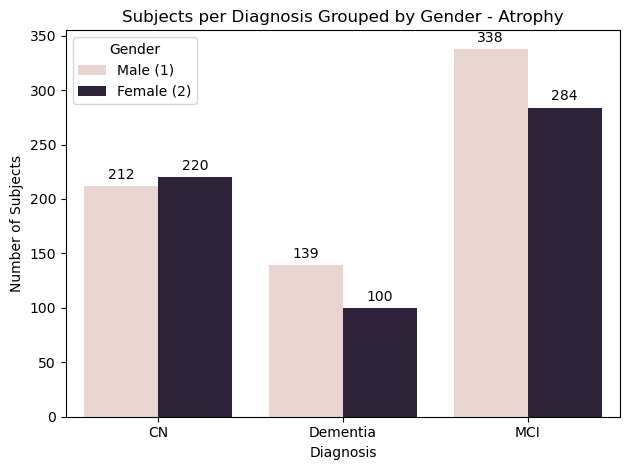

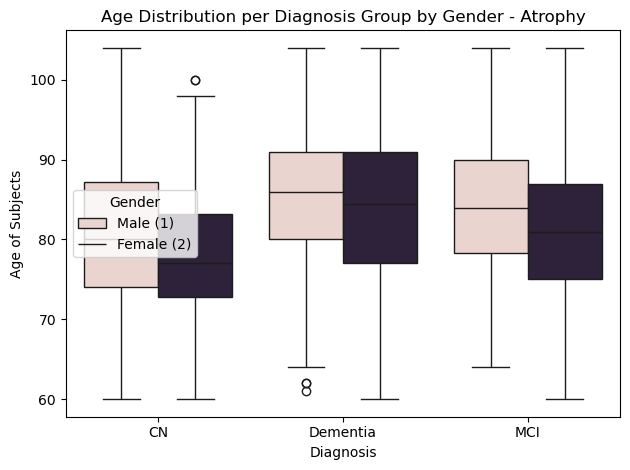

In [11]:
#Number of subjects with each diagnosis
diagnosis_counts = mri_trainset[dx].value_counts().sort_index()
print("Counts per diagnosis:\n", diagnosis_counts)

#Diagnosis analysis per gender 
ax_mri_diag = sns.countplot(data=mri_trainset, x=dx, hue=gender)
plt.xlabel('Diagnosis')
plt.ylabel('Number of Subjects')
plt.title('Subjects per Diagnosis Grouped by Gender - Atrophy')
plt.legend(title='Gender', labels=['Male (1)', 'Female (2)'])  # adjust labels if needed
for container in ax_mri_diag.containers:
    ax_mri_diag.bar_label(container, label_type='edge', padding=3, fontsize=10)
plt.tight_layout()
plt.show()

#Age analysis by diagnosis, per gender
sns.boxplot(data=mri_trainset, x=dx, y=age, hue=gender)
plt.xlabel('Diagnosis')
plt.ylabel('Age of Subjects')
plt.title('Age Distribution per Diagnosis Group by Gender - Atrophy')
plt.legend(title='Gender', labels=['Male (1)', 'Female (2)'], loc="best") 
plt.tight_layout()
plt.show()



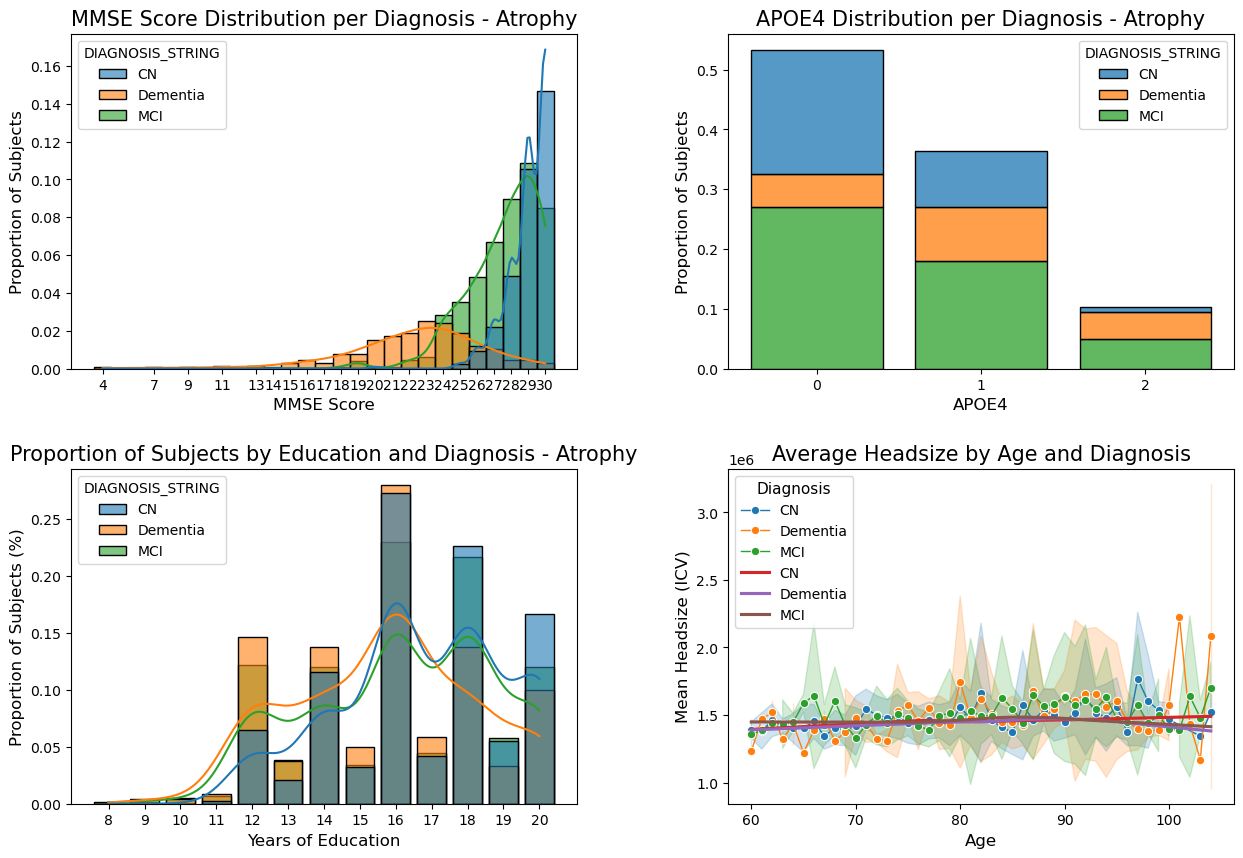

In [12]:
#Unique MRI scans analysis - MMSE_score, ApoE4, Headsize, YearsEDUC

#Create subplots
fig, axs = plt.subplots(2,2, figsize=(15,10))
plt.subplots_adjust(wspace=0.3, hspace=0.3)

#MMSE scores per diagnosis normalised by the number of subjects in each diagnosis
sns.histplot(data=mri_trainset, x=mmse_score, hue=dx, kde=True, multiple="layer", alpha = 0.6, ax=axs[0,0], stat="probability", discrete=True)
axs[0,0].set_title("MMSE Score Distribution per Diagnosis - Atrophy", fontsize=15)
axs[0,0].set_xlabel("MMSE Score", fontsize=12)
axs[0,0].set_ylabel("Proportion of Subjects", fontsize=12)
unique_mmse_atro = sorted(mri_trainset[mmse_score].dropna().unique())
axs[0,0].set_xticks(unique_mmse_atro)

#APOE4 carriers per diagnosis layered bar chart with colours normalised for each diagnosis
sns.histplot(data=mri_trainset, x=apoe4, hue=dx, multiple="stack", ax=axs[0,1], stat="probability", discrete=True, shrink=.8)
axs[0,1].set_title("APOE4 Distribution per Diagnosis - Atrophy", fontsize=15)
axs[0,1].set_xlabel("APOE4", fontsize=12)
axs[0,1].set_ylabel("Proportion of Subjects", fontsize=12)
unique_apoe4_atro = sorted(mri_trainset[apoe4].dropna().unique())
axs[0,1].set_xticks(unique_apoe4_atro)

#Years of education per diagnosis histogram overlaps for each diagnosis # Proportion (normalized within each diagnosis group)
sns.histplot(data=mri_trainset, x=educ, hue=dx, kde=True, multiple="layer", alpha=0.6, ax=axs[1,0], stat="probability", common_norm=False, discrete=True, shrink=.8)
axs[1,0].set_title("Proportion of Subjects by Education and Diagnosis - Atrophy", fontsize=15)
axs[1,0].set_xlabel("Years of Education", fontsize=12)
axs[1,0].set_ylabel("Proportion of Subjects (%)", fontsize=12)
unique_educ_years_atro = sorted(mri_trainset[educ].dropna().unique())
axs[1,0].set_xticks(unique_educ_years_atro)

# Age distribution of headsize per diagnosis (averaged per age)
sns.lineplot(data=mri_trainset, x=age, y=headsize_mri,hue=dx,estimator='mean', errorbar='sd', lw=1, marker='o', err_style='band', ax=axs[1,1])
# Smooth trend
for label in mri_trainset[dx].unique():
    subset = mri_trainset[mri_trainset[dx] == label]
    sns.regplot(
        data=subset,
        x=age,
        y=headsize_mri,
        lowess=True,
        scatter=False,
        label=label,
        ax=axs[1,1]
    )


axs[1,1].set_title("Average Headsize by Age and Diagnosis", fontsize=15)
axs[1,1].set_xlabel("Age", fontsize=12)
axs[1,1].set_ylabel("Mean Headsize (ICV)", fontsize=12)
axs[1,1].legend(title="Diagnosis", fontsize=10, title_fontsize=11)



plt.show()





Counts per retirement status:
 PTNOTRT
0.0     256
1.0    1012
2.0      25
Name: count, dtype: int64


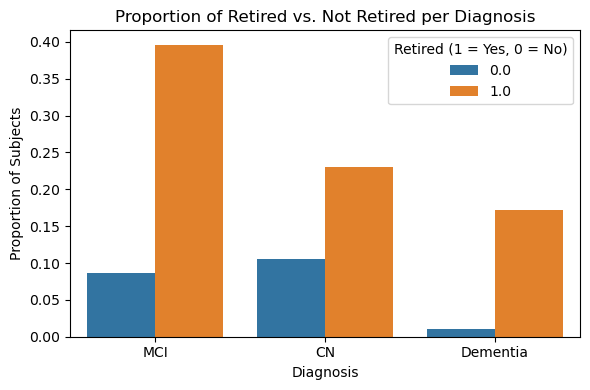

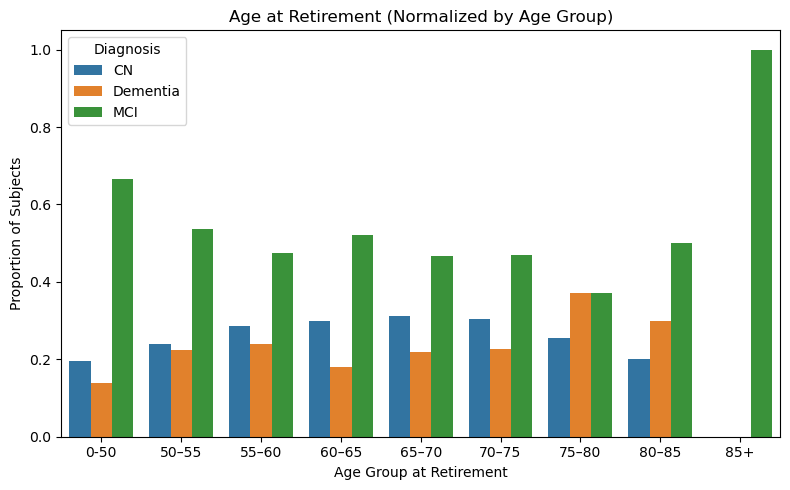

In [13]:
# Count retirement status values (e.g., 0, 1, 2) 
retirement_counts = mri_trainset[retirement].value_counts().sort_index()
print("Counts per retirement status:\n", retirement_counts)

# Filter to only include 0 (not retired) and 1 (retired)
mri_filtered = mri_trainset[mri_trainset[retirement].isin([0, 1])].copy()

# GRAPH 1: Proportion Retired vs. Not Retired per Diagnosis ---
# Shows normalized proportions within each diagnosis group
retirement_dist_mri = (mri_filtered[[dx, retirement]].value_counts(normalize=True).reset_index(name="Proportion"))

plt.figure(figsize=(6, 4))
sns.barplot(data=retirement_dist_mri, x=dx, y="Proportion", hue=retirement)
plt.title("Proportion of Retired vs. Not Retired per Diagnosis")
plt.xlabel("Diagnosis")
plt.ylabel("Proportion of Subjects")
plt.legend(title="Retired (1 = Yes, 0 = No)")
plt.tight_layout()

# GRAPH 2: Age at Retirement by Diagnosis (Normalized by Age Group) ---

# Step 1: Filter and build a DataFrame from scratch
retired = mri_trainset[[dx, retirement, y_retirement, y_of_birth, y_startadsym, retire_age]].copy()

# Step 2: Apply filters
retired = retired[(retired[retirement] == 1) & (retired[y_retirement].notna()) & (retired[y_of_birth].notna())].copy()

# Step 3: Assign age group manually using logical conditions
conditions = [
    (retired[retire_age] <50),
    (retired[retire_age] >= 50) & (retired[retire_age] < 55),
    (retired[retire_age] >= 55) & (retired[retire_age] < 60),
    (retired[retire_age] >= 60) & (retired[retire_age] < 65),
    (retired[retire_age] >= 65) & (retired[retire_age] < 70),
    (retired[retire_age] >= 70) & (retired[retire_age] < 75),
    (retired[retire_age] >= 75) & (retired[retire_age] < 80),
    (retired[retire_age] >= 80) & (retired[retire_age] < 85),
    (retired[retire_age] >= 85)
]

labels = ["0-50", "50–55", "55–60", "60–65", "65–70", "70–75", "75–80", "80–85","85+"]

if "RetireAgeGroup" in retired.columns:
    retired.drop(columns=["RetireAgeGroup"], inplace=True)

retired["RetireAgeGroup"] = np.select(conditions, labels)

# Step 5: Create normalized group distribution
counts = retired.groupby(["RetireAgeGroup", dx]).size().reset_index(name="Count")
total_per_group = counts.groupby("RetireAgeGroup")["Count"].transform("sum")
counts["Proportion"] = counts["Count"] / total_per_group

# Step 6: Plot
plt.figure(figsize=(8, 5))
sns.barplot(data=counts, x="RetireAgeGroup", y="Proportion", hue=dx)
plt.title("Age at Retirement (Normalized by Age Group)")
plt.xlabel("Age Group at Retirement")
plt.ylabel("Proportion of Subjects")
plt.legend(title="Diagnosis")
plt.tight_layout()
plt.show()

# Retirement Year vs. AD Symptom Onset (MCI & AD Only) ---
## there isn't enough data to assess the year or retirement vs year of onset AD symptoms.
#not enough subjects have data about the year of onset. 


# --- Show all plots ---
plt.show()

In [14]:
# List of columns to analyze
columns_mri = [age, mmse_score, apoe4, educ, retire_age, headsize_mri]

# Create a function to return descriptive statistics for each column
def get_stats(df, column_name):
    return df[column_name].describe()

# Create an empty list to store the stats DataFrames
stats_list_mri = []

cn_atro = mri_trainset[mri_trainset[dx] == 'CN']
mci_atro = mri_trainset[mri_trainset[dx] == 'MCI']
dem_atro = mri_trainset[mri_trainset[dx] == 'Dementia']


# For each variable (column), get the statistics for each group (General, CN, MCI, Dementia, ICV)
for column in columns_mri:
    general_stats = get_stats(mri_trainset, column)
    cn_stats = get_stats(cn_atro, column)
    mci_stats = get_stats(mci_atro, column)
    dem_stats = get_stats(dem_atro, column)
    
    # Combine all the statistics into a single DataFrame for this variable
    combined_stats = pd.DataFrame({
        'General': general_stats,
        'CN': cn_stats,
        'MCI': mci_stats,
        'Dementia': dem_stats
    })

    # Add a row with the variable name
    combined_stats['Variable'] = column
    
    # Append the combined stats for this variable to the stats list
    stats_list_mri.append(combined_stats)

# Concatenate all the DataFrames for each variable
final_stats_mri = pd.concat(stats_list_mri)
pd.options.display.float_format = '{:.2f}'.format

# Reorder columns to have 'Variable' as the first column
final_stats_mri = final_stats_mri[['Variable', 'General', 'CN', 'MCI', 'Dementia']]

# Display the final summary table
print(final_stats_mri)



                 Variable    General         CN        MCI   Dementia
count                 Age    1293.00     432.00     622.00     239.00
mean                  Age      81.83      78.91      82.80      84.58
std                   Age       9.35       9.33       8.94       9.14
min                   Age      60.00      60.00      60.00      60.00
25%                   Age      75.00      73.00      77.00      79.00
50%                   Age      82.00      78.00      82.50      85.00
75%                   Age      89.00      85.00      89.00      91.00
max                   Age     104.00     104.00     104.00     104.00
count             MMSCORE    1281.00     430.00     613.00     238.00
mean              MMSCORE      27.09      29.03      27.56      22.39
std               MMSCORE       3.31       1.18       2.12       3.96
min               MMSCORE       4.00      20.00      18.00       4.00
25%               MMSCORE      26.00      29.00      26.00      20.00
50%               MM

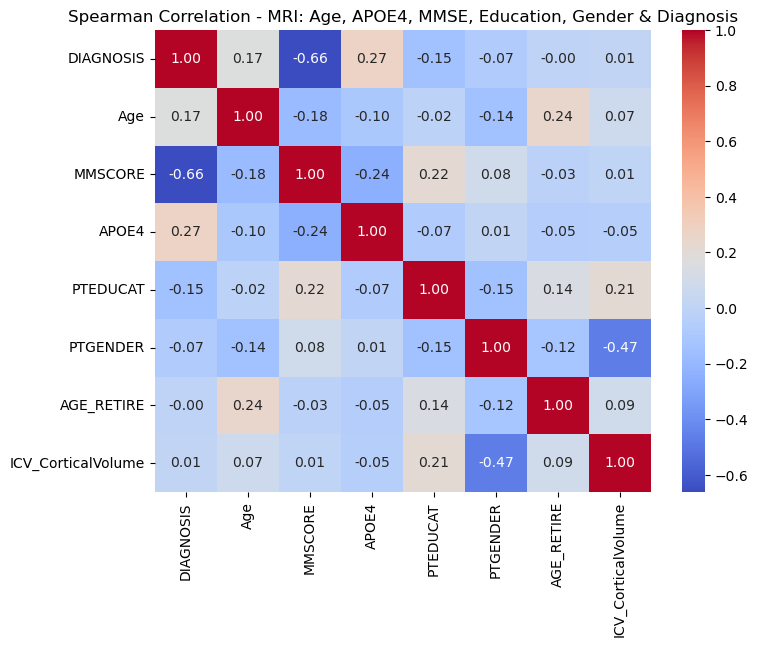

Kendall's MRI Correlation with Diagnosis:
Age: τ = 0.132, p = 0.00000
MMSE Score: τ = -0.571, p = 0.00000
APOE4 Score: τ = 0.250, p = 0.00000
Years of Education: τ = -0.120, p = 0.00002
Gender: τ = -0.070, p = 0.02938
Age at Retirement: τ = -0.003, p = 0.91620
Optimization terminated successfully.
         Current function value: 0.692275
         Iterations 8
                          MNLogit Regression Results                          
Dep. Variable:              DIAGNOSIS   No. Observations:                  877
Model:                        MNLogit   Df Residuals:                      863
Method:                           MLE   Df Model:                           12
Date:                Wed, 06 Aug 2025   Pseudo R-squ.:                  0.3309
Time:                        00:02:56   Log-Likelihood:                -607.13
converged:                       True   LL-Null:                       -907.32
Covariance Type:            nonrobust   LLR p-value:                8.753e-121
DIAGN

In [15]:
# Ensure data is clean
diagnosis_num = "DIAGNOSIS"  # Encode diagnosis as ordinal
corr_mri_data = mri_trainset[categories_mri].dropna().sort_values([diagnosis_num], ascending=True)


# Convert gender to numeric if not already (1 = Male, 2 = Female)
corr_mri_data[gender] = corr_mri_data[gender].replace({"Male": 1.0, "Female": 2.0}).astype(int)
#pd.set_option('future.no_silent_downcasting', True)

# Compute Spearman's correlation
correlation_matrix = corr_mri_data.corr(method="spearman")

# Display heatmap
plt.figure(figsize=(8,6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Spearman Correlation - MRI: Age, APOE4, MMSE, Education, Gender & Diagnosis")
plt.show()

# Kendall's MRI correlation significance tests
mri_age, p_mri_age = stats.kendalltau(corr_mri_data[age], corr_mri_data[diagnosis_num])
mri_mmse, p_mri_mmse = stats.kendalltau(corr_mri_data[mmse_score], corr_mri_data[diagnosis_num])
mri_apoe4, p_mri_apoe4 = stats.kendalltau(corr_mri_data[apoe4], corr_mri_data[diagnosis_num])
mri_educ, p_mri_educ = stats.kendalltau(corr_mri_data[educ], corr_mri_data[diagnosis_num])
mri_gender, p_mri_gender = stats.kendalltau(corr_mri_data[gender], corr_mri_data[diagnosis_num])
mri_retire, p_mri_retire = stats.kendalltau(corr_mri_data[retire_age], corr_mri_data[diagnosis_num])

print("Kendall's MRI Correlation with Diagnosis:")
print(f"Age: τ = {mri_age:.3f}, p = {p_mri_age:.5f}")
print(f"MMSE Score: τ = {mri_mmse:.3f}, p = {p_mri_mmse:.5f}")
print(f"APOE4 Score: τ = {mri_apoe4:.3f}, p = {p_mri_apoe4:.5f}")
print(f"Years of Education: τ = {mri_educ:.3f}, p = {p_mri_educ:.5f}")
print(f"Gender: τ = {mri_gender:.3f}, p = {p_mri_gender:.5f}")
print(f"Age at Retirement: τ = {mri_retire:.3f}, p = {p_mri_retire:.5f}")

# Define predictor variables
X = corr_mri_data[[age, mmse_score, apoe4, educ, gender, retire_age]]
X = sm.add_constant(X)  # Add intercept

# Define categorical dependent variable (CN=0, MCI=1, Dementia=2)
y = corr_mri_data[diagnosis_num].astype("category")
y = y.cat.reorder_categories([1, 2, 3], ordered=True)  # Ensures correct ordering


# Run multinomial logistic regression
mn_mri_logit_model = sm.MNLogit(y, X).fit()
print(mn_mri_logit_model.summary())



## Amyloid Beta Pet Data - Preparation:

Here I look at the data per tracer type and filter the data to include only PET scans with FBP as it contains more data. 
Then I create the longitudinal test set and filter the trainset from the later examinations and CNs that later develop a diagnosis. Then remove outliers. 

In [16]:
#create the subset of potential train data with data for Amyloid Beta PET
ab_pet_trainset = train_multimodal.dropna(subset=[ab_ind]) 
ab_pet_trainset = ab_pet_trainset.copy(deep=True)

#filter the dataset for tracer types and choose the one with the higher amount of scans
tracerz_amy = [t for t in ab_pet_trainset["TRACER_amy"].unique().tolist() if type(t) == str]
print("Amyloid SUVR data tracers: " + ", ".join(tracerz_amy))
trc_amy1 = tracerz_amy[0]
florbetapir_amyloid_rows = ( trc_amy1 == ab_pet_trainset["TRACER_amy"] ).values
print(f"\tThere are {sum(florbetapir_amyloid_rows)} first visit {trc_amy1} rows")
trc_amy2 = tracerz_amy[1]
florbetapir_amyloid_rows = ( trc_amy2 == ab_pet_trainset["TRACER_amy"] ).values
print(f"\tThere are {sum(florbetapir_amyloid_rows)} first visit {trc_amy2} rows")

#Show number of subjects in each group per diagnosis
tracer_diagnosis_counts = ab_pet_trainset.groupby("TRACER_amy")[dx].value_counts().unstack()

# Display results
print(f"\n{tracer_diagnosis_counts}\n")
print("As there are more FBP rows of data - we will choose to use this tracer of the two.\n")

#filter for FBP
ab_pet_trainset = ab_pet_trainset[ab_pet_trainset["TRACER_amy"] == trc_amy1]
num_train_ab = (ab_pet_trainset[rid].nunique())-1

# Filter for MRI longitudinal data test set
## Test set 6 - Amyloid Beta Longitudinal Test Set
test_longitudinal_ab = df_merge2025[
    (df_merge2025[rid].isin(ab_pet_trainset[rid])) &  # RID is in train set
    (df_merge2025[rid].isin(longitudinal_rid_list)) &  # RID has multiple visits
    (df_merge2025[ab_ind].notnull())  # Amyloid Beta data is present on all visits
].sort_values([rid, dat]).reset_index()
list_longitudinal_ab = test_longitudinal_ab.duplicated(subset=[rid], keep=False)
list_longitudinal_ab = test_longitudinal_ab.loc[list_longitudinal_ab, rid].unique().copy()
test_longitudinal_ab = test_longitudinal_ab[(test_longitudinal_ab[rid].isin(list_longitudinal_ab))].sort_values([rid, dat]).reset_index()
num_test_longitudinal_ab = test_longitudinal_ab[rid].nunique()

print(f"First Filtered Train set Amyloid Beta PET (FBP) : The number of subjects with AB PET visits (and possibly one more scan type) is {num_train_ab}.\n")
print(f"Longitudinal Test set Amyloid Beta : There are {len(test_longitudinal_ab)} entries in the of longitudinal PET Amyloid Beta test set.\nThere are {num_test_longitudinal_ab} subjects in this data set.\n")

#remove duplicates from the trainset (they appear in the longitudinal testset)
ab_pet_trainset[dat] = pd.to_datetime(ab_pet_trainset[dat]) # Ensure EXAMDATE is in datetime format
ab_pet_trainset = ab_pet_trainset.sort_values(by=[rid, dat])
ab_pet_trainset = ab_pet_trainset.drop_duplicates(subset=[rid], keep='first')  # Keep first occurrence per RID

# Testing to see that all CN stay CN over time (This is for only some of the CN in ab_pet_trainset) 
test_longitudinal_ab[dat] = pd.to_datetime(test_longitudinal_ab[dat]) # Ensure EXAMDATE is in datetime format
test_longitudinal_ab = test_longitudinal_ab.sort_values(by=[rid, dat])

# Group by RID and apply the diagnosis check function
non_cn_rids_ab = test_longitudinal_ab.groupby('RID').filter(check_diagnosis_change)

# Get the unique RIDs of patients who are not really CN
unique_non_cn_rids_ab = non_cn_rids_ab['RID'].unique()
num_unique_non_cn_rids_ab = len(unique_non_cn_rids_ab)
print(f"There are {num_unique_non_cn_rids_ab} out of {test_longitudinal_ab[rid].nunique()} subjects the Longitudinal AB data that develop MCI/Dementia over time.")
ab_pet_trainset = ab_pet_trainset[~ab_pet_trainset[rid].isin(unique_non_cn_rids_ab)]
print("These RIDs have been removed from the ab_pet_trainset as they might bias the control population results.")

# Filter out subjects who are above 105 years old
ab_pet_trainset = ab_pet_trainset[ab_pet_trainset[age] <= 105]
print("\nComparison shows that there are 3 subjects over 105 y/o - so I removed them from the dataset (outliers).")

# Filter for CN and female to reduce the female bias
ab_cn_female_ids = set(ab_pet_trainset[(ab_pet_trainset[dx] == 'CN') & (ab_pet_trainset[gender] == 'Female')][rid])
list_common_ab_tau = [10114, 10146, 4900, 10274, 6082, 7048, 10185, 10059, 10092, 10030, 10063, 10096, 6801, 10258, 10293, 6429, 10270]
print(f"\nNumber of female CN subjects in AB and MRI dataset: {len(list_common_ab_mri)}, these have been removed.")
print(f"\nNumber of female CN subjects in AB and TAU dataset: {len(list_common_ab_tau)}, these have been removed.")
ab_pet_trainset = ab_pet_trainset[~ab_pet_trainset[rid].isin(list_common_ab_mri)]
ab_pet_trainset = ab_pet_trainset[~ab_pet_trainset[rid].isin(list_common_ab_tau)]

num_train_ab = (ab_pet_trainset[rid].nunique())
print(f"\nTrain set Amyloid Beta PET (FBP) : The number of subjects with AB PET visits (and possibly one more scan type) is {num_train_ab}.\n")



Amyloid SUVR data tracers: FBP, FBB
	There are 1662 first visit FBP rows
	There are 713 first visit FBB rows

DIAGNOSIS_STRING   CN  Dementia  MCI
TRACER_amy                          
FBB               406        88  219
FBP               624       314  724

As there are more FBP rows of data - we will choose to use this tracer of the two.

First Filtered Train set Amyloid Beta PET (FBP) : The number of subjects with AB PET visits (and possibly one more scan type) is 956.

Longitudinal Test set Amyloid Beta : There are 1187 entries in the of longitudinal PET Amyloid Beta test set.
There are 464 subjects in this data set.

There are 51 out of 464 subjects the Longitudinal AB data that develop MCI/Dementia over time.
These RIDs have been removed from the ab_pet_trainset as they might bias the control population results.

Comparison shows that there are 3 subjects over 105 y/o - so I removed them from the dataset (outliers).

Number of female CN subjects in AB and MRI dataset: 15, these h

## Amyloid Beta PET Data - Analysis: 

Counts per diagnosis:
 DIAGNOSIS_STRING
CN          272
Dementia    191
MCI         409
Name: count, dtype: int64


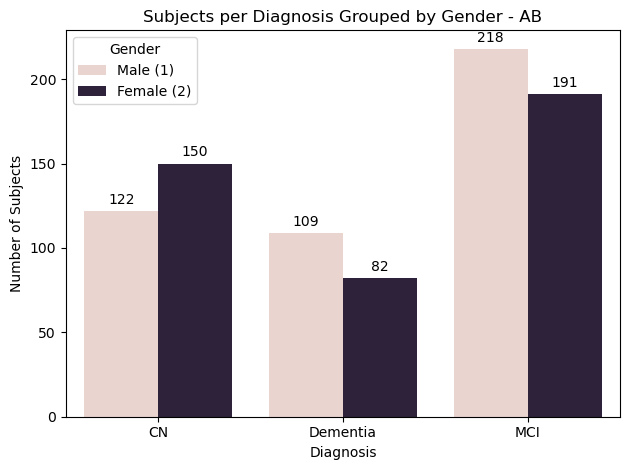

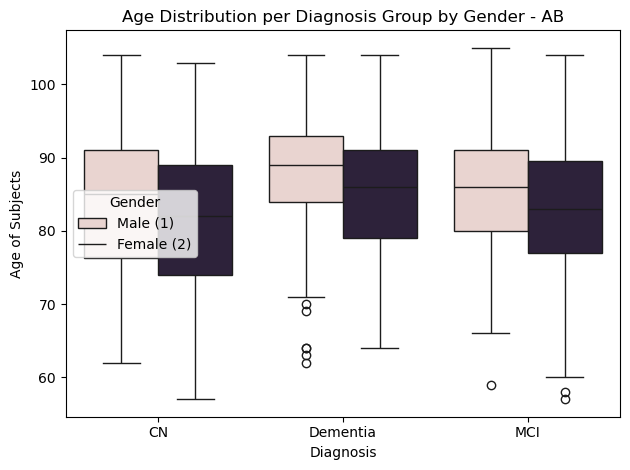

In [17]:
#Number of subjects with each diagnosis
diagnosis_counts = ab_pet_trainset[dx].value_counts().sort_index()
print("Counts per diagnosis:\n", diagnosis_counts)

#Diagnosis analysis per gender
#Gender- Male=1, Female=2
ax_ab_diag = sns.countplot(data=ab_pet_trainset, x=dx, hue=gender)
plt.xlabel('Diagnosis')
plt.ylabel('Number of Subjects')
plt.title('Subjects per Diagnosis Grouped by Gender - AB')
plt.legend(title='Gender', labels=['Male (1)', 'Female (2)'])  # adjust labels if needed
for container in ax_ab_diag.containers:
    ax_ab_diag.bar_label(container, label_type='edge', padding=3, fontsize=10)
plt.tight_layout()
plt.show()

#Age analysis by diagnosis, per gender
sns.boxplot(data=ab_pet_trainset, x=dx, y=age, hue=gender)
plt.xlabel('Diagnosis')
plt.ylabel('Age of Subjects')
plt.title('Age Distribution per Diagnosis Group by Gender - AB')
plt.legend(title='Gender', labels=['Male (1)', 'Female (2)'], loc="best") 
plt.tight_layout()
plt.show()



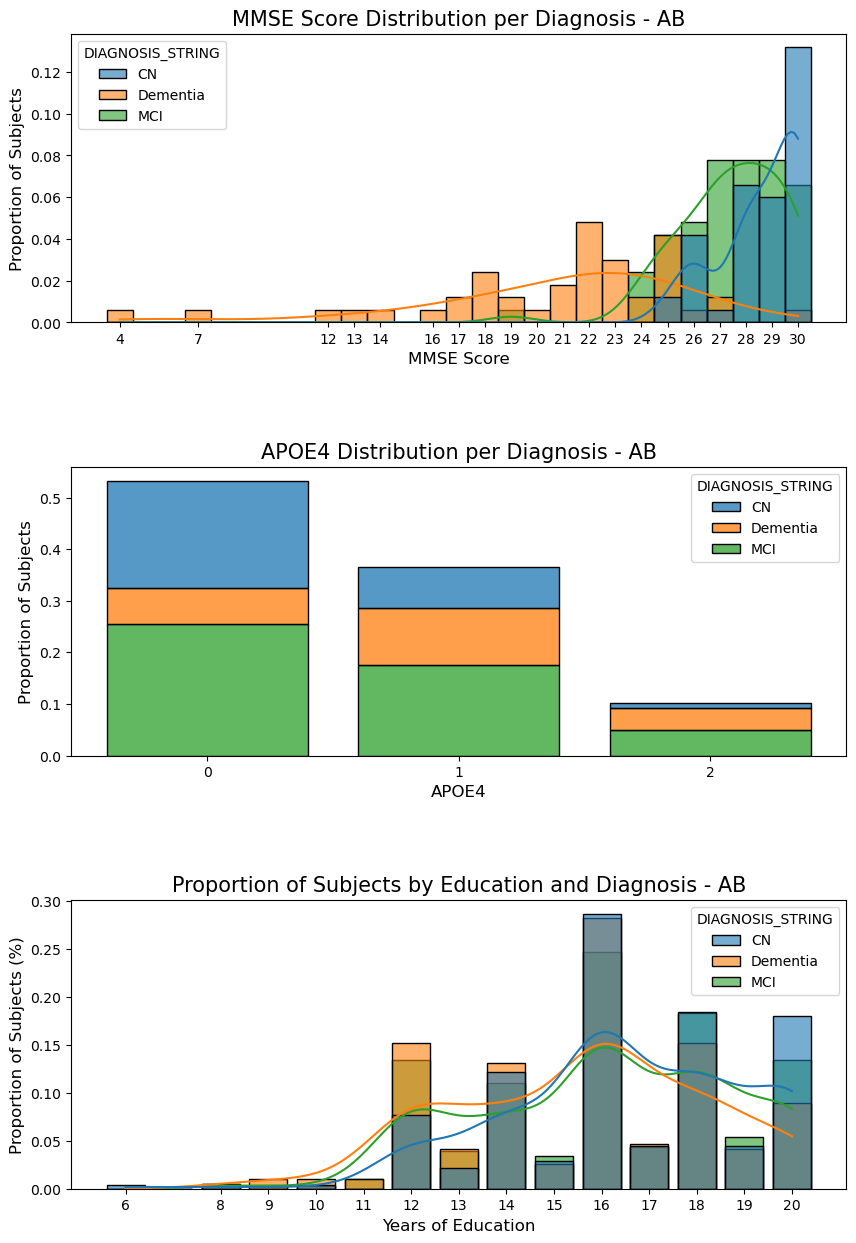

In [18]:
#Unique AB scans analysis - MMSE_score, ApoE4, YearsEDUC

#Create subplots
fig, axs = plt.subplots(3,1, figsize=(10,15))
plt.subplots_adjust(wspace=0.3, hspace=0.5)

#MMSE scores per diagnosis
sns.histplot(data=ab_pet_trainset, x=mmse_score, hue=dx, kde=True, multiple="layer", alpha = 0.6, ax=axs[0], stat="probability", discrete=True)
axs[0].set_title("MMSE Score Distribution per Diagnosis - AB", fontsize=15)
axs[0].set_xlabel("MMSE Score", fontsize=12)
axs[0].set_ylabel("Proportion of Subjects", fontsize=12)
unique_mmse_ab = sorted(ab_pet_trainset[mmse_score].dropna().unique())
axs[0].set_xticks(unique_mmse_ab)

#APOE4 carriers per diagnosis layered bar chart with colours for each diagnosis
sns.histplot(data=ab_pet_trainset, x=apoe4, hue=dx, multiple="stack", ax=axs[1], stat="probability", discrete=True, shrink=.8)
axs[1].set_title("APOE4 Distribution per Diagnosis - AB", fontsize=15)
axs[1].set_xlabel("APOE4", fontsize=12)
axs[1].set_ylabel("Proportion of Subjects", fontsize=12)
unique_apoe4_ab = sorted(ab_pet_trainset[apoe4].dropna().unique())
axs[1].set_xticks(unique_apoe4_ab)

#Years of education per diagnosis histogram overlaps for each diagnosis # Show proportion instead of count # Normalize within each diagnosis group
sns.histplot(data=ab_pet_trainset, x=educ, hue=dx, kde=True, multiple="layer", alpha=0.6, ax=axs[2], stat="probability", common_norm=False, discrete=True, shrink=.8)
axs[2].set_title("Proportion of Subjects by Education and Diagnosis - AB", fontsize=15)
axs[2].set_xlabel("Years of Education", fontsize=12)
axs[2].set_ylabel("Proportion of Subjects (%)", fontsize=12)
unique_educ_years_ab = sorted(ab_pet_trainset[educ].dropna().unique())
axs[2].set_xticks(unique_educ_years_ab)


plt.show()




Counts per retirement status:
 PTNOTRT
0.00    157
1.00    692
2.00     23
Name: count, dtype: int64


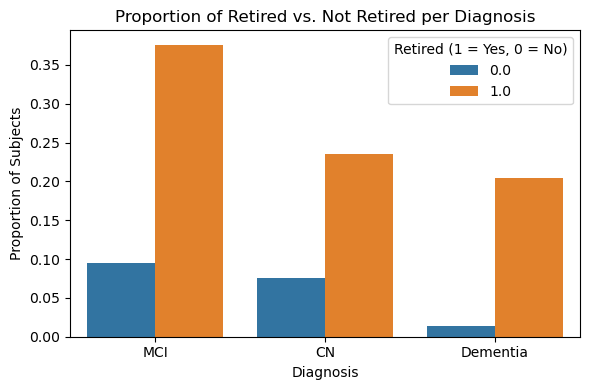

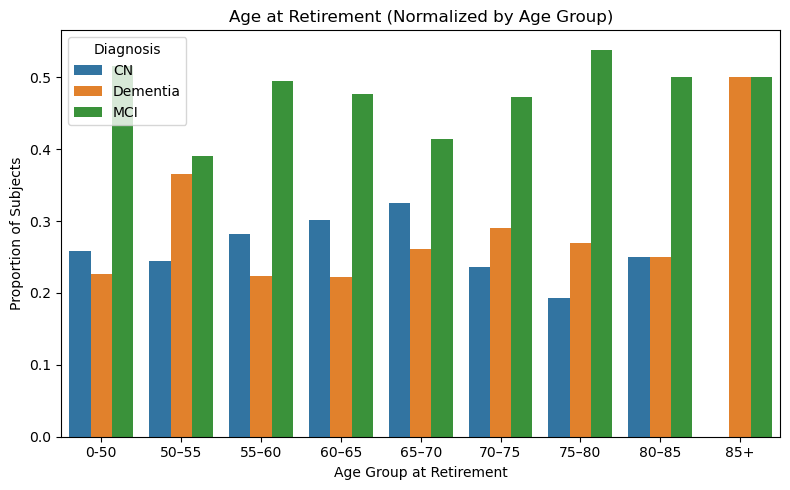

In [19]:
# Count retirement status values (e.g., 0, 1, 2) 
retirement_counts = ab_pet_trainset[retirement].value_counts().sort_index()
print("Counts per retirement status:\n", retirement_counts)

# Filter to only include 0 (not retired) and 1 (retired)
ab_filtered = ab_pet_trainset[ab_pet_trainset[retirement].isin([0, 1])].copy()

# GRAPH 1: Proportion Retired vs. Not Retired per Diagnosis ---
# Shows normalized proportions within each diagnosis group
retirement_dist_ab = (ab_filtered[[dx, retirement]].value_counts(normalize=True).reset_index(name="Proportion"))

plt.figure(figsize=(6, 4))
sns.barplot(data=retirement_dist_ab, x=dx, y="Proportion", hue=retirement)
plt.title("Proportion of Retired vs. Not Retired per Diagnosis")
plt.xlabel("Diagnosis")
plt.ylabel("Proportion of Subjects")
plt.legend(title="Retired (1 = Yes, 0 = No)")
plt.tight_layout()

# GRAPH 2: Age at Retirement by Diagnosis (Normalized by Age Group) ---

# Step 1: Filter and build a DataFrame from scratch
retired = ab_pet_trainset[[dx, retirement, y_retirement, y_of_birth, y_startadsym, retire_age]].copy()

# Step 2: Apply filters
retired = retired[(retired[retirement] == 1) & (retired[y_retirement].notna()) & (retired[y_of_birth].notna())].copy()

# Step 3: Assign age group manually using logical conditions
conditions = [
    (retired[retire_age] <50),
    (retired[retire_age] >= 50) & (retired[retire_age] < 55),
    (retired[retire_age] >= 55) & (retired[retire_age] < 60),
    (retired[retire_age] >= 60) & (retired[retire_age] < 65),
    (retired[retire_age] >= 65) & (retired[retire_age] < 70),
    (retired[retire_age] >= 70) & (retired[retire_age] < 75),
    (retired[retire_age] >= 75) & (retired[retire_age] < 80),
    (retired[retire_age] >= 80) & (retired[retire_age] < 85),
    (retired[retire_age] >= 85)
]

labels = ["0-50", "50–55", "55–60", "60–65", "65–70", "70–75", "75–80", "80–85","85+"]

if "RetireAgeGroup" in retired.columns:
    retired.drop(columns=["RetireAgeGroup"], inplace=True)

retired["RetireAgeGroup"] = np.select(conditions, labels)

# Step 5: Create normalized group distribution
counts = retired.groupby(["RetireAgeGroup", dx]).size().reset_index(name="Count")
total_per_group = counts.groupby("RetireAgeGroup")["Count"].transform("sum")
counts["Proportion"] = counts["Count"] / total_per_group

# Step 6: Plot
plt.figure(figsize=(8, 5))
sns.barplot(data=counts, x="RetireAgeGroup", y="Proportion", hue=dx)
plt.title("Age at Retirement (Normalized by Age Group)")
plt.xlabel("Age Group at Retirement")
plt.ylabel("Proportion of Subjects")
plt.legend(title="Diagnosis")
plt.tight_layout()
plt.show()

# Retirement Year vs. AD Symptom Onset (MCI & AD Only) ---
## there isn't enough data to assess the year or retirement vs year of onset AD symptoms.
#not enough subjects have data about the year of onset. 


# --- Show all plots ---
plt.show()

In [20]:
# List of columns to analyze
columns_ab = [age, mmse_score, apoe4, educ, retire_age]

# Create an empty list to store the stats DataFrames
stats_list_ab = []

cn_ab = ab_pet_trainset[ab_pet_trainset[dx] == 'CN']
mci_ab = ab_pet_trainset[ab_pet_trainset[dx] == 'MCI']
dem_ab = ab_pet_trainset[ab_pet_trainset[dx] == 'Dementia']


# For each variable (column), get the statistics for each group (General, CN, MCI, Dementia, ICV)
for column in columns_ab:
    general_stats = get_stats(ab_pet_trainset, column)
    cn_stats = get_stats(cn_ab, column)
    mci_stats = get_stats(mci_ab, column)
    dem_stats = get_stats(dem_ab, column)
    
    # Combine all the statistics into a single DataFrame for this variable
    combined_stats = pd.DataFrame({
        'General': general_stats,
        'CN': cn_stats,
        'MCI': mci_stats,
        'Dementia': dem_stats
    })

    # Add a row with the variable name
    combined_stats['Variable'] = column
    
    # Append the combined stats for this variable to the stats list
    stats_list_ab.append(combined_stats)

# Concatenate all the DataFrames for each variable
final_stats_ab = pd.concat(stats_list_ab)
pd.options.display.float_format = '{:.2f}'.format

# Reorder columns to have 'Variable' as the first column
final_stats_ab = final_stats_ab[['Variable', 'General', 'CN', 'MCI', 'Dementia']]

# Display the final summary table
print(final_stats_ab)





         Variable  General     CN    MCI  Dementia
count         Age   872.00 272.00 409.00    191.00
mean          Age    84.42  82.30  84.71     86.81
std           Age     9.38  10.26   8.72      8.82
min           Age    57.00  57.00  57.00     62.00
25%           Age    78.00  75.00  79.00     82.00
50%           Age    85.00  83.50  85.00     88.00
75%           Age    91.00  90.00  91.00     93.00
max           Age   105.00 104.00 105.00    104.00
count     MMSCORE   167.00  53.00  70.00     44.00
mean      MMSCORE    26.07  28.62  27.43     20.84
std       MMSCORE     4.39   1.55   2.04      5.09
min       MMSCORE     4.00  25.00  19.00      4.00
25%       MMSCORE    25.00  28.00  26.00     18.00
50%       MMSCORE    27.00  29.00  28.00     22.00
75%       MMSCORE    29.00  30.00  29.00     24.25
max       MMSCORE    30.00  30.00  30.00     30.00
count       APOE4   822.00 244.00 393.00    185.00
mean        APOE4     0.57   0.33   0.57      0.88
std         APOE4     0.67   0.

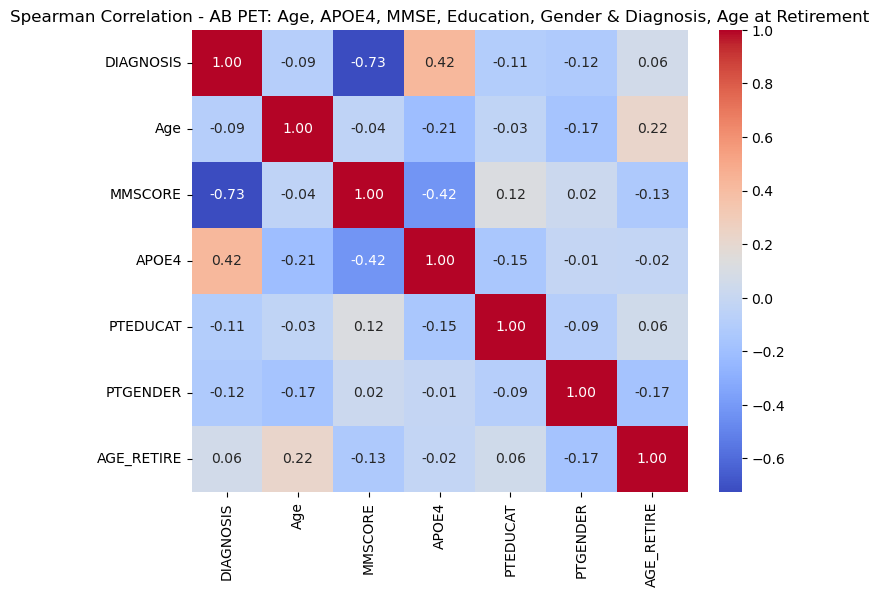

Kendall's Amyloid Beta Correlation with Diagnosis:
Age: τ = -0.066, p = 0.31144
MMSE Score: τ = -0.617, p = 0.00000
APOE4 Score: τ = 0.389, p = 0.00000
Years of Education: τ = -0.086, p = 0.20945
Gender: τ = -0.115, p = 0.14289
Age of Retirement: τ = -0.003, p = 0.91620
Optimization terminated successfully.
         Current function value: 0.583610
         Iterations 9
                          MNLogit Regression Results                          
Dep. Variable:              DIAGNOSIS   No. Observations:                  146
Model:                        MNLogit   Df Residuals:                      132
Method:                           MLE   Df Model:                           12
Date:                Wed, 06 Aug 2025   Pseudo R-squ.:                  0.4610
Time:                        00:02:57   Log-Likelihood:                -85.207
converged:                       True   LL-Null:                       -158.08
Covariance Type:            nonrobust   LLR p-value:                 4.119

In [21]:
# Ensure data is clean
diagnosis_num = "DIAGNOSIS"  # Encode diagnosis as ordinal
corr_ab_data = ab_pet_trainset[categories].dropna().sort_values([diagnosis_num],ascending=True)

# Convert gender to numeric if not already (1 = Male, 2 = Female)
corr_ab_data[gender] = corr_ab_data[gender].replace({"Male": 1.0, "Female": 2.0}).astype(int)

# Compute Spearman's correlation
correlation_matrix_ab = corr_ab_data.corr(method="spearman")

# Display heatmap
plt.figure(figsize=(8,6))
sns.heatmap(correlation_matrix_ab, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Spearman Correlation - AB PET: Age, APOE4, MMSE, Education, Gender & Diagnosis, Age at Retirement")
plt.show()

# Kendall's Amyloid Beta correlation significance tests
ab_age, p_ab_age = stats.kendalltau(corr_ab_data[age], corr_ab_data[diagnosis_num])
ab_mmse, p_ab_mmse = stats.kendalltau(corr_ab_data[mmse_score], corr_ab_data[diagnosis_num])
ab_apoe4, p_ab_apoe4 = stats.kendalltau(corr_ab_data[apoe4], corr_ab_data[diagnosis_num])
ab_educ, p_ab_educ = stats.kendalltau(corr_ab_data[educ], corr_ab_data[diagnosis_num])
ab_gender, p_ab_gender = stats.kendalltau(corr_ab_data[gender], corr_ab_data[diagnosis_num])
ab_retire, p_ab_retire = stats.kendalltau(corr_mri_data[retire_age], corr_mri_data[diagnosis_num])

print("Kendall's Amyloid Beta Correlation with Diagnosis:")
print(f"Age: τ = {ab_age:.3f}, p = {p_ab_age:.5f}")
print(f"MMSE Score: τ = {ab_mmse:.3f}, p = {p_ab_mmse:.5f}")
print(f"APOE4 Score: τ = {ab_apoe4:.3f}, p = {p_ab_apoe4:.5f}")
print(f"Years of Education: τ = {ab_educ:.3f}, p = {p_ab_educ:.5f}")
print(f"Gender: τ = {ab_gender:.3f}, p = {p_ab_gender:.5f}")
print(f"Age of Retirement: τ = {ab_retire:.3f}, p = {p_ab_retire:.5f}")

# Define predictor variables
X = corr_ab_data[[age, mmse_score, apoe4, educ, gender, retire_age]]
X = sm.add_constant(X)  # Add intercept

# Define categorical dependent variable (CN=0, MCI=1, Dementia=2)
y = corr_ab_data[diagnosis_num]

# Run multinomial logistic regression
mnlogit_model = sm.MNLogit(y, X).fit()
print(mnlogit_model.summary())


## Tau PET Data - Preparation:

Once again adjust data per tracer and then filter out the test set and remove the following dates from the trainset. The filter outliers. 

In [22]:
#create the subset of potential train data with data for Tau PET
tau_pet_trainset = train_multimodal.dropna(subset=[tau_ind])
tau_pet_trainset = tau_pet_trainset.copy(deep=True)

# Tau tracers analysis
tracerz_tau = [t for t in tau_pet_trainset["TRACER_tau"].unique().tolist() if type(t) == str]
print("Tau SUVR data tracers: " + ", ".join(tracerz_tau))
trc_tau1 = tracerz_tau[0]
florbetapir_tau_rows = ( trc_tau1 == tau_pet_trainset["TRACER_tau"] ).values
print(f"\tThere are {sum(florbetapir_tau_rows)} first visit {trc_tau1} rows")
trc_tau2 = tracerz_tau[1]
florbetapir_tau_rows = ( trc_tau2 == tau_pet_trainset["TRACER_tau"] ).values
print(f"\tThere are {sum(florbetapir_tau_rows)} first visit {trc_tau2} rows")

tracer_diagnosis_counts = tau_pet_trainset.groupby("TRACER_tau")["DIAGNOSIS"].value_counts().unstack()

# Display results
print(f"\n{tracer_diagnosis_counts}\n")
print("As there are more FTP rows of data - we will choose to use this tracer of the two.\n")

tau_pet_trainset = tau_pet_trainset[tau_pet_trainset["TRACER_tau"]== trc_tau1]
num_train_tau= (tau_pet_trainset[rid].nunique())

# Filter for MRI longitudinal data test set
## Test set 7 - Tau Longitudinal Test Set
test_longitudinal_tau = df_merge2025[
    (df_merge2025[rid].isin(tau_pet_trainset[rid])) &  # RID is in train set
    (df_merge2025[rid].isin(longitudinal_rid_list)) &  # RID has multiple visits
    (df_merge2025[tau_ind].notnull())  # Tau data is present on all visits
].sort_values([rid, dat]).reset_index()
list_longitudinal_tau = test_longitudinal_tau.duplicated(subset=[rid], keep=False)
list_longitudinal_tau = test_longitudinal_tau.loc[list_longitudinal_tau, rid].unique().copy()
test_longitudinal_tau = test_longitudinal_tau[(test_longitudinal_tau[rid].isin(list_longitudinal_tau))].sort_values([rid, dat]).reset_index()
num_test_longitudinal_tau = test_longitudinal_tau[rid].nunique()


print(f"First Filtered Trainset Tau PET (FTP) : The number of subjects with Tau visits (and possibly one more scan type) is {num_train_tau}.\n")
print(f"Longitudinal Test set Tau : There are {len(test_longitudinal_tau)} entries in the of longitudinal PET Tau test set.\nThere are {num_test_longitudinal_tau} subjects in this data set.\n")

#remove duplicates from the trainset (they appear in the longitudinal testset)
tau_pet_trainset[dat] = pd.to_datetime(tau_pet_trainset[dat]) # Ensure EXAMDATE is in datetime format
tau_pet_trainset = tau_pet_trainset.sort_values(by=[rid, dat])
tau_pet_trainset = tau_pet_trainset.drop_duplicates(subset=[rid], keep='first')  # Keep first occurrence per RID


# Testing to see that all CN stay CN over time (This is for only some of the CN in tau_pet_trainset) 
test_longitudinal_tau[dat] = pd.to_datetime(test_longitudinal_tau[dat]) # Ensure EXAMDATE is in datetime format
test_longitudinal_tau = test_longitudinal_tau.sort_values(by=['RID', 'EXAMDATE'])

# Group by RID and apply the diagnosis check function
non_cn_rids_tau = test_longitudinal_tau.groupby('RID').filter(check_diagnosis_change)

# Get the unique RIDs of patients who are not really CN
unique_non_cn_rids_tau = non_cn_rids_tau['RID'].unique()
num_unique_non_cn_rids_tau = len(unique_non_cn_rids_tau)

print(f"There are {num_unique_non_cn_rids_tau} out of {test_longitudinal_tau[rid].nunique()} subjects the Longitudinal TAU data that develop MCI/Dementia over time.")
tau_pet_trainset = tau_pet_trainset[~tau_pet_trainset[rid].isin(unique_non_cn_rids_tau)]
print("These RIDs have been removed from the tau_pet_trainset as they might bias the control population results.")

# Filter for CN and female to reduce the female bias
tau_cn_female_ids = set(tau_pet_trainset[(tau_pet_trainset[dx] == 'CN') & (tau_pet_trainset[gender] == 'Female')][rid])
print(f"\nNumber of female CN subjects in TAU and MRI dataset: {len(list_common_tau_mri)}")
print(f"Number of female CN subjects in TAU and AB dataset: {len(list_common_ab_tau)}")
tau_pet_trainset = tau_pet_trainset[~tau_pet_trainset[rid].isin(list_common_ab_tau)]
tau_pet_trainset = tau_pet_trainset[~tau_pet_trainset[rid].isin(list_common_tau_mri)]
print("These Subjects have been removed in over to create a homogeneous representation of Male/Females within the diagnosis types.")




print("Additionally removing 50 randomly selected female CN subjects to reduce CN female bias.")
# Filter for CN females not in the exclusion lists
eligible_cn_females = tau_pet_trainset[
    (tau_pet_trainset[dx] == 'CN') &
    (tau_pet_trainset[gender] == 2) & 
    (~tau_pet_trainset[rid].isin(rids_to_exclude))
]

# Randomly sample 90 RIDs (without replacement)
if eligible_cn_females[rid].nunique() >= 90:
    random_50_rids = eligible_cn_females[rid].sample(n=50, random_state=42).tolist()
else:
    random_50_rids = eligible_cn_females[rid].tolist()

tau_pet_trainset = tau_pet_trainset[~tau_pet_trainset[rid].isin(random_50_rids)]

# Final count
num_train_tau = (tau_pet_trainset[rid].nunique())
print(f"\nTrain set TAU PET (FBP) : The number of subjects with TAU PET visits (and possibly one more scan type) is {num_train_tau}.\n")




Tau SUVR data tracers: FTP, MK6240
	There are 1033 first visit FTP rows
	There are 25 first visit MK6240 rows

DIAGNOSIS   1.00  2.00  3.00
TRACER_tau                  
FTP          534   335   164
MK6240         6    12     7

As there are more FTP rows of data - we will choose to use this tracer of the two.

First Filtered Trainset Tau PET (FTP) : The number of subjects with Tau visits (and possibly one more scan type) is 674.

Longitudinal Test set Tau : There are 593 entries in the of longitudinal PET Tau test set.
There are 234 subjects in this data set.

There are 22 out of 234 subjects the Longitudinal TAU data that develop MCI/Dementia over time.
These RIDs have been removed from the tau_pet_trainset as they might bias the control population results.

Number of female CN subjects in TAU and MRI dataset: 8
Number of female CN subjects in TAU and AB dataset: 17
These Subjects have been removed in over to create a homogeneous representation of Male/Females within the diagnosis typ

## Tau PET Data - Analysis: 

Counts per diagnosis:
 DIAGNOSIS_STRING
CN          269
Dementia     83
MCI         225
Name: count, dtype: int64


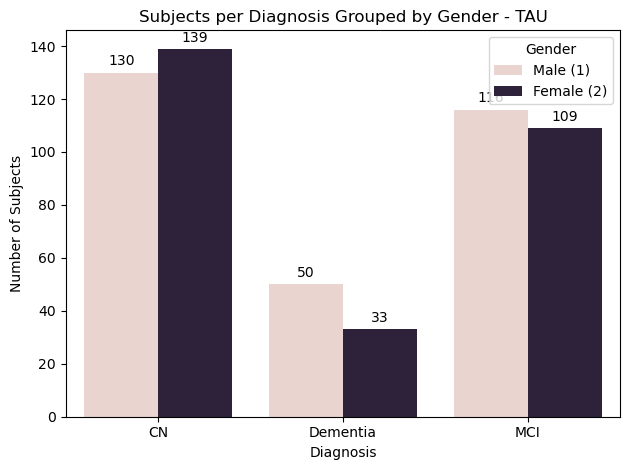

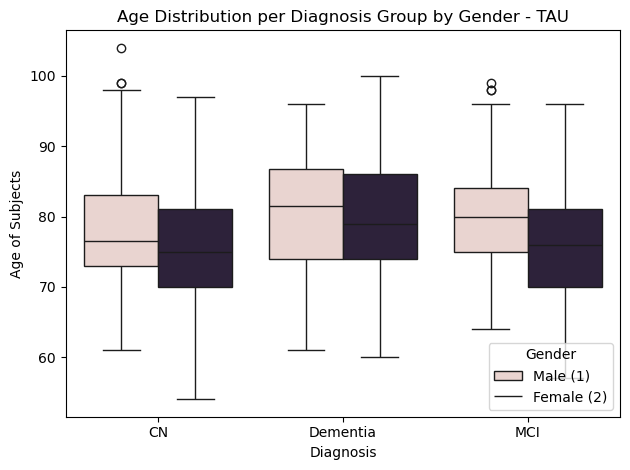

In [23]:
#Number of subjects with each diagnosis
diagnosis_counts = tau_pet_trainset[dx].value_counts().sort_index()
print("Counts per diagnosis:\n", diagnosis_counts)

#Diagnosis analysis per gender
#Gender- Male=1, Female=2
ax_tau_diag = sns.countplot(data=tau_pet_trainset, x=dx, hue=gender)
plt.xlabel('Diagnosis')
plt.ylabel('Number of Subjects')
plt.title('Subjects per Diagnosis Grouped by Gender - TAU')
plt.legend(title='Gender', labels=['Male (1)', 'Female (2)'])  # adjust labels if needed
for container in ax_tau_diag.containers:
    ax_tau_diag.bar_label(container, label_type='edge', padding=3, fontsize=10)
plt.tight_layout()
plt.show()

#Age analysis by diagnosis, per gender
sns.boxplot(data=tau_pet_trainset, x=dx, y=age, hue=gender)
plt.xlabel('Diagnosis')
plt.ylabel('Age of Subjects')
plt.title('Age Distribution per Diagnosis Group by Gender - TAU')
plt.legend(title='Gender', labels=['Male (1)', 'Female (2)'], loc="best") 
plt.tight_layout()
plt.show()



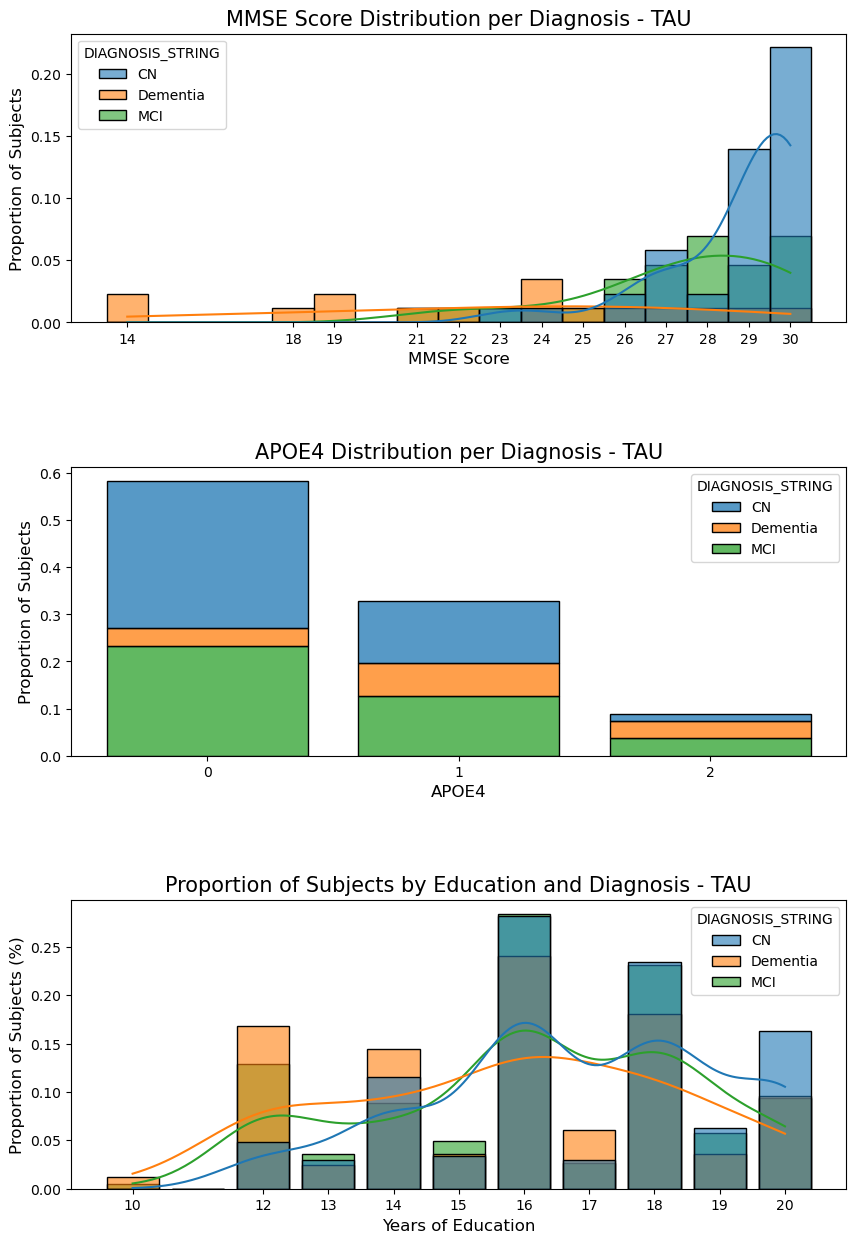

In [24]:
#Unique TAU scans analysis - MMSE_score, ApoE4, YearsEDUC

#Create subplots
fig, axs = plt.subplots(3,1, figsize=(10,15))
plt.subplots_adjust(wspace=0.3, hspace=0.5)

#MMSE scores per diagnosis
sns.histplot(data=tau_pet_trainset, x=mmse_score, hue=dx, kde=True, multiple="layer", alpha = 0.6, ax=axs[0], stat="probability", discrete=True)
axs[0].set_title("MMSE Score Distribution per Diagnosis - TAU", fontsize=15)
axs[0].set_xlabel("MMSE Score", fontsize=12)
axs[0].set_ylabel("Proportion of Subjects", fontsize=12)
unique_mmse_tau = sorted(tau_pet_trainset[mmse_score].dropna().unique())
axs[0].set_xticks(unique_mmse_tau)

#APOE4 carriers per diagnosis layered bar chart with colours for each diagnosis
sns.histplot(data=tau_pet_trainset, x=apoe4, hue=dx, multiple="stack", ax=axs[1], stat="probability", discrete=True, shrink=.8)
axs[1].set_title("APOE4 Distribution per Diagnosis - TAU", fontsize=15)
axs[1].set_xlabel("APOE4", fontsize=12)
axs[1].set_ylabel("Proportion of Subjects", fontsize=12)
unique_apoe4_tau = sorted(tau_pet_trainset[apoe4].dropna().unique())
axs[1].set_xticks(unique_apoe4_tau)

#Years of education per diagnosis histogram overlaps for each diagnosis # Show proportion instead of count # Normalize within each diagnosis group
sns.histplot(data=tau_pet_trainset, x=educ, hue=dx, kde=True, multiple="layer", alpha=0.6, ax=axs[2], stat="probability", common_norm=False, discrete=True, shrink=.8)
axs[2].set_title("Proportion of Subjects by Education and Diagnosis - TAU", fontsize=15)
axs[2].set_xlabel("Years of Education", fontsize=12)
axs[2].set_ylabel("Proportion of Subjects (%)", fontsize=12)
unique_educ_years_tau = sorted(tau_pet_trainset[educ].dropna().unique())
axs[2].set_xticks(unique_educ_years_tau)


plt.show()




Counts per retirement status:
 PTNOTRT
0.00    124
1.00    446
2.00      7
Name: count, dtype: int64


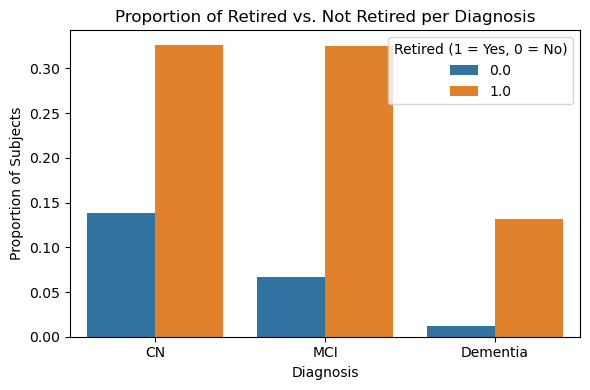

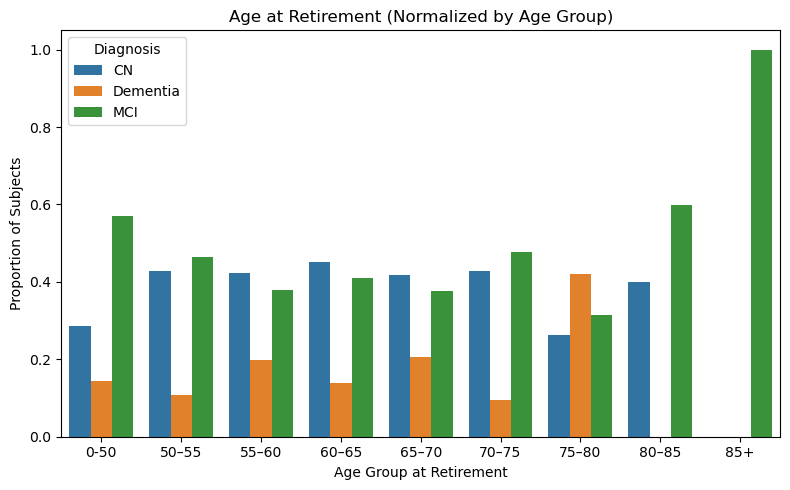

In [25]:
# Count retirement status values (e.g., 0, 1, 2) 
retirement_counts = tau_pet_trainset[retirement].value_counts().sort_index()
print("Counts per retirement status:\n", retirement_counts)

# Filter to only include 0 (not retired) and 1 (retired)
tau_filtered = tau_pet_trainset[tau_pet_trainset[retirement].isin([0, 1])].copy()

# GRAPH 1: Proportion Retired vs. Not Retired per Diagnosis ---
# Shows normalized proportions within each diagnosis group
retirement_dist_tau = (tau_filtered[[dx, retirement]].value_counts(normalize=True).reset_index(name="Proportion"))

plt.figure(figsize=(6, 4))
sns.barplot(data=retirement_dist_tau, x=dx, y="Proportion", hue=retirement)
plt.title("Proportion of Retired vs. Not Retired per Diagnosis")
plt.xlabel("Diagnosis")
plt.ylabel("Proportion of Subjects")
plt.legend(title="Retired (1 = Yes, 0 = No)")
plt.tight_layout()

# GRAPH 2: Age at Retirement by Diagnosis (Normalized by Age Group) ---

# Step 1: Filter and build a DataFrame from scratch
retired = tau_pet_trainset[[dx, retirement, y_retirement, y_of_birth, y_startadsym, retire_age]].copy()

# Step 2: Apply filters
retired = retired[(retired[retirement] == 1) & (retired[y_retirement].notna()) & (retired[y_of_birth].notna())].copy()

# Step 3: Assign age group manually using logical conditions
conditions = [
    (retired[retire_age] <50),
    (retired[retire_age] >= 50) & (retired[retire_age] < 55),
    (retired[retire_age] >= 55) & (retired[retire_age] < 60),
    (retired[retire_age] >= 60) & (retired[retire_age] < 65),
    (retired[retire_age] >= 65) & (retired[retire_age] < 70),
    (retired[retire_age] >= 70) & (retired[retire_age] < 75),
    (retired[retire_age] >= 75) & (retired[retire_age] < 80),
    (retired[retire_age] >= 80) & (retired[retire_age] < 85),
    (retired[retire_age] >= 85)
]

labels = ["0-50", "50–55", "55–60", "60–65", "65–70", "70–75", "75–80", "80–85","85+"]

if "RetireAgeGroup" in retired.columns:
    retired.drop(columns=["RetireAgeGroup"], inplace=True)

retired["RetireAgeGroup"] = np.select(conditions, labels)

# Step 5: Create normalized group distribution
counts = retired.groupby(["RetireAgeGroup", dx]).size().reset_index(name="Count")
total_per_group = counts.groupby("RetireAgeGroup")["Count"].transform("sum")
counts["Proportion"] = counts["Count"] / total_per_group

# Step 6: Plot
plt.figure(figsize=(8, 5))
sns.barplot(data=counts, x="RetireAgeGroup", y="Proportion", hue=dx)
plt.title("Age at Retirement (Normalized by Age Group)")
plt.xlabel("Age Group at Retirement")
plt.ylabel("Proportion of Subjects")
plt.legend(title="Diagnosis")
plt.tight_layout()
plt.show()


# --- Show all plots ---
plt.show()

In [26]:
# List of columns to analyze
columns_tau = [age, mmse_score, apoe4, educ, retire_age]

# Create an empty list to store the stats DataFrames
stats_list_tau = []

cn_tau = tau_pet_trainset[tau_pet_trainset[dx] == 'CN']
mci_tau = tau_pet_trainset[tau_pet_trainset[dx] == 'MCI']
dem_tau = tau_pet_trainset[tau_pet_trainset[dx] == 'Dementia']


# For each variable (column), get the statistics for each group (General, CN, MCI, Dementia)
for column in columns_tau:
    general_stats = get_stats(tau_pet_trainset, column)
    cn_stats = get_stats(cn_tau, column)
    mci_stats = get_stats(mci_tau, column)
    dem_stats = get_stats(dem_tau, column)
    
    # Combine all the statistics into a single DataFrame for this variable
    combined_stats = pd.DataFrame({
        'General': general_stats,
        'CN': cn_stats,
        'MCI': mci_stats,
        'Dementia': dem_stats
    })

    # Add a row with the variable name
    combined_stats['Variable'] = column
    
    # Append the combined stats for this variable to the stats list
    stats_list_tau.append(combined_stats)

# Concatenate all the DataFrames for each variable
final_stats_tau = pd.concat(stats_list_tau)
pd.options.display.float_format = '{:.2f}'.format

# Reorder columns to have 'Variable' as the first column
final_stats_tau = final_stats_tau[['Variable', 'General', 'CN', 'MCI', 'Dementia']]

# Display the final summary table
print(final_stats_tau)





         Variable  General     CN    MCI  Dementia
count         Age   577.00 269.00 225.00     83.00
mean          Age    77.82  76.82  78.15     80.18
std           Age     8.70   8.81   8.24      9.14
min           Age    54.00  54.00  57.00     60.00
25%           Age    73.00  73.00  72.00     74.00
50%           Age    78.00  76.00  79.00     81.00
75%           Age    83.00  82.00  83.00     86.50
max           Age   104.00 104.00  99.00    100.00
count     MMSCORE    86.00  42.00  28.00     16.00
mean      MMSCORE    27.17  28.76  27.32     22.75
std       MMSCORE     3.55   1.69   2.48      4.93
min       MMSCORE    14.00  23.00  21.00     14.00
25%       MMSCORE    26.00  28.25  26.00     19.00
50%       MMSCORE    28.50  29.00  28.00     24.00
75%       MMSCORE    30.00  30.00  29.00     26.25
max       MMSCORE    30.00  30.00  30.00     30.00
count       APOE4   522.00 239.00 208.00     75.00
mean        APOE4     0.50   0.35   0.51      0.97
std         APOE4     0.65   0.

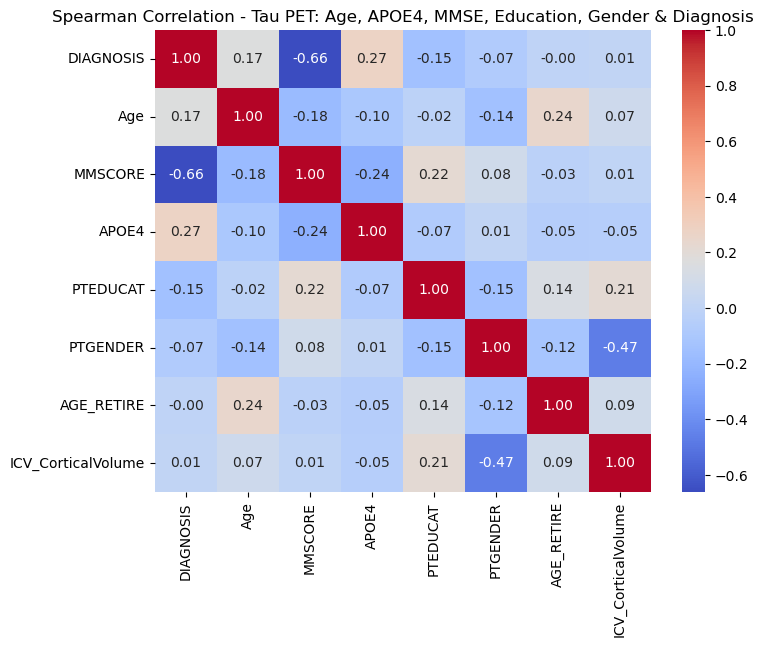

Kendall's Tau Correlation with Diagnosis:
Age: τ = -0.026, p = 0.78766
MMSE Score: τ = -0.507, p = 0.00000
APOE4 Score: τ = 0.372, p = 0.00093
Years of Education: τ = -0.099, p = 0.33660
Gender: τ = -0.045, p = 0.70125
Age of Retirement: τ = 0.017, p = 0.86025
Optimization terminated successfully.
         Current function value: 0.655584
         Iterations 8
                          MNLogit Regression Results                          
Dep. Variable:              DIAGNOSIS   No. Observations:                   67
Model:                        MNLogit   Df Residuals:                       53
Method:                           MLE   Df Model:                           12
Date:                Wed, 06 Aug 2025   Pseudo R-squ.:                  0.3780
Time:                        00:02:58   Log-Likelihood:                -43.924
converged:                       True   LL-Null:                       -70.615
Covariance Type:            nonrobust   LLR p-value:                 3.522e-07
DIAGN

In [27]:
# Ensure data is clean
diagnosis_num = "DIAGNOSIS"  # Encode diagnosis as ordinal
corr_tau_data = tau_pet_trainset[categories].dropna().sort_values([diagnosis_num],ascending=True)

# Convert gender to numeric if not already (1 = Male, 2 = Female)
corr_tau_data[gender] = corr_tau_data[gender].replace({"Male": 1.0, "Female": 2.0}).astype(int)

# Compute Spearman's correlation
correlation_matrix_tau = corr_tau_data.corr(method="spearman")

# Display heatmap
plt.figure(figsize=(8,6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Spearman Correlation - Tau PET: Age, APOE4, MMSE, Education, Gender & Diagnosis")
plt.show()

# Kendall's Tau correlation significance tests
tau_age, p_tau_age = stats.kendalltau(corr_tau_data[age], corr_tau_data[diagnosis_num])
tau_mmse, p_tau_mmse = stats.kendalltau(corr_tau_data[mmse_score], corr_tau_data[diagnosis_num])
tau_apoe4, p_tau_apoe4 = stats.kendalltau(corr_tau_data[apoe4], corr_tau_data[diagnosis_num])
tau_educ, p_tau_educ = stats.kendalltau(corr_tau_data[educ], corr_tau_data[diagnosis_num])
tau_gender, p_tau_gender = stats.kendalltau(corr_tau_data[gender], corr_tau_data[diagnosis_num])
tau_retire, p_tau_retire = stats.kendalltau(corr_tau_data[retire_age], corr_tau_data[diagnosis_num])

print("Kendall's Tau Correlation with Diagnosis:")
print(f"Age: τ = {tau_age:.3f}, p = {p_tau_age:.5f}")
print(f"MMSE Score: τ = {tau_mmse:.3f}, p = {p_tau_mmse:.5f}")
print(f"APOE4 Score: τ = {tau_apoe4:.3f}, p = {p_tau_apoe4:.5f}")
print(f"Years of Education: τ = {tau_educ:.3f}, p = {p_tau_educ:.5f}")
print(f"Gender: τ = {tau_gender:.3f}, p = {p_tau_gender:.5f}")
print(f"Age of Retirement: τ = {tau_retire:.3f}, p = {p_tau_retire:.5f}")

# Define predictor variables
X = corr_tau_data[[age, mmse_score, apoe4, educ, gender, retire_age]]
X = sm.add_constant(X)  # Add intercept

# Define categorical dependent variable (CN=0, MCI=1, Dementia=2)
y = corr_tau_data[diagnosis_num]

# Run multinomial logistic regression
mnlogit_model = sm.MNLogit(y, X).fit()
print(mnlogit_model.summary())


## Final Train Sets : 
Decisions for biomarkers (brain regions) per modality. 

In [28]:
#MRI
biomarkers_mri = [
    'Frontal_lobe_volume', 
    'Occipital_lobe_volume',
    'Parietal_lobe_volume',
    'Temporal_lobe_volume',
    'MTL_volume',
    'Frontal_lobe_Asymmetry_MRI_L', 
    'Frontal_lobe_Asymmetry_MRI_R',
    'Occipital_lobe_Asymmetry_MRI_L', 
    'Occipital_lobe_Asymmetry_MRI_R',
    'Parietal_lobe_Asymmetry_MRI_L', 
    'Parietal_lobe_Asymmetry_MRI_R',
    'Temporal_lobe_Asymmetry_MRI_L', 
    'Temporal_lobe_Asymmetry_MRI_R',
    'MTL_Asymmetry_MRI_L', 
    'MTL_Asymmetry_MRI_R'
]

columns_of_interest_mri = required +  categories_mri + biomarkers_mri 

mri_final = mri_trainset[columns_of_interest_mri].fillna(0)
print(f" This is MRI Trainset:\n {mri_final}\n\n")

longitudinal_mri_final = test_longitudinal_mri[columns_of_interest_mri].fillna(0)
print(f" This is MRI Longitudinal Testset:\n {longitudinal_mri_final}\n\n")


#AB
biomarkers_ab = [
    'Frontal_lobe_SUVR_weighted_ab', 
    'Occipital_lobe_SUVR_weighted_ab',
    'Parietal_lobe_SUVR_weighted_ab',
    'Temporal_lobe_SUVR_weighted_ab',
    'MTL_SUVR_weighted_ab',
    'Frontal_lobe_Asymmetry_ab_L', 
    'Frontal_lobe_Asymmetry_ab_R',
    'Occipital_lobe_Asymmetry_ab_L', 
    'Occipital_lobe_Asymmetry_ab_R',
    'Parietal_lobe_Asymmetry_ab_L', 
    'Parietal_lobe_Asymmetry_ab_R',
    'Temporal_lobe_Asymmetry_ab_L', 
    'Temporal_lobe_Asymmetry_ab_R',
    'MTL_Asymmetry_ab_L', 
    'MTL_Asymmetry_ab_R'
]

columns_of_interest_ab = required +  categories + biomarkers_ab

ab_final = ab_pet_trainset[columns_of_interest_ab].fillna(0)
print(f" This is AB Trainset:\n {ab_final}\n\n")

longitudinal_ab_final = test_longitudinal_ab[columns_of_interest_ab].fillna(0)
print(f" This is AB Longitudinal Testset:\n {longitudinal_ab_final}\n\n")

#TAU
biomarkers_tau = [
    'Frontal_lobe_SUVR_weighted_tau', 
    'Occipital_lobe_SUVR_weighted_tau',
    'Parietal_lobe_SUVR_weighted_tau',
    'Temporal_lobe_SUVR_weighted_tau',
    'MTL_SUVR_weighted_tau',
    'Frontal_lobe_Asymmetry_tau_L', 
    'Frontal_lobe_Asymmetry_tau_R',
    'Occipital_lobe_Asymmetry_tau_L', 
    'Occipital_lobe_Asymmetry_tau_R',
    'Parietal_lobe_Asymmetry_tau_L', 
    'Parietal_lobe_Asymmetry_tau_R',
    'Temporal_lobe_Asymmetry_tau_L', 
    'Temporal_lobe_Asymmetry_tau_R',
    'MTL_Asymmetry_tau_L', 
    'MTL_Asymmetry_tau_R'
]

columns_of_interest_tau = required +  categories + biomarkers_tau

tau_final = tau_pet_trainset[columns_of_interest_tau].fillna(0)
print(f" This is TAU Trainset:\n {tau_final}\n\n")

longitudinal_tau_final = test_longitudinal_tau[columns_of_interest_tau].fillna(0)
print(f" This is TAU Longitudinal Testset:\n {longitudinal_tau_final}\n\n")

#unified data set 
columns_of_interest_all = required +  categories_mri + biomarkers_mri + biomarkers_ab + biomarkers_tau

multimodal_final = test_multimodal[columns_of_interest_all].fillna(0)
print(f" This is Multimodal Testset:\n {multimodal_final}\n\n")




 This is MRI Trainset:
          RID   EXAMDATE DIAGNOSIS_STRING  DIAGNOSIS  Age  MMSCORE  APOE4  \
141       23 2010-12-21               CN       1.00   91    26.00   0.00   
160       30 2007-11-13         Dementia       3.00  100    22.00   0.00   
512       72 2019-10-16               CN       1.00   90    28.00   0.00   
539       74 2021-01-11               CN       1.00   98    29.00   0.00   
591       86 2006-05-08               CN       1.00  100     0.00   0.00   
...      ...        ...              ...        ...  ...      ...    ...   
21860  10242 2024-09-09               CN       1.00   72    27.00   0.00   
21868  10246 2024-09-10               CN       1.00   73    30.00   0.00   
21878  10252 2024-09-16               CN       1.00   60    29.00   0.00   
21907  10273 2024-09-30               CN       1.00   71    30.00   0.00   
21911  10275 2024-10-01               CN       1.00   65    30.00   0.00   

       PTEDUCAT  PTGENDER  AGE_RETIRE  ...  Frontal_lobe_Asymme

In [29]:
# --- Unique subjects across all datasets ---
all_subjects = pd.concat([
    mri_final[rid],
    longitudinal_mri_final[rid],
    ab_final[rid],
    longitudinal_ab_final[rid],
    tau_final[rid],
    longitudinal_tau_final[rid],
    multimodal_final[rid]
])
unique_subjects = all_subjects.nunique()
print(f"Total number of unique subjects across all datasets: {unique_subjects}")

# --- Subset of datasets with cross-sectional (non-longitudinal) data ---
all_subjects_cross = pd.concat([
    mri_final,
    ab_final,
    tau_final,
    multimodal_final
])

# --- Percentages of available metadata ---
percent_with_mmse = (all_subjects_cross[mmse_score].notna().sum() / len(all_subjects_cross)) * 100
print(f"{percent_with_mmse:.2f}% of subjects have MMSE Score data.")

percent_with_apoe4 = (all_subjects_cross[apoe4].notna().sum() / len(all_subjects_cross)) * 100
print(f"{percent_with_apoe4:.2f}% of subjects have APOE4 data.")

percent_with_educ = (all_subjects_cross[educ].notna().sum() / len(all_subjects_cross)) * 100
print(f"{percent_with_educ:.2f}% of subjects have Number of Years of Education data.")

percent_with_gender = (all_subjects_cross[gender].notna().sum() / len(all_subjects_cross)) * 100
print(f"{percent_with_gender:.2f}% of subjects have Gender data.")


percent_with_icv = (all_subjects_cross[headsize_mri].notna().sum() / len(all_subjects_cross)) * 100
print(f"{percent_with_icv:.2f}% of subjects have ICV data.\n")

# Phase count, if available
if "PHASE" in all_subjects_cross.columns:
    print("Phase distribution:\n", all_subjects_cross["PHASE"].value_counts())

# --- Unique longitudinal subjects ---
longitudinal_subjects = pd.concat([
    longitudinal_mri_final[rid],
    longitudinal_ab_final[rid],
    longitudinal_tau_final[rid]
])
unique_longitudinal_subjects = longitudinal_subjects.nunique()
print(f"Number of unique longitudinal subjects: {unique_longitudinal_subjects}")


Total number of unique subjects across all datasets: 1936
100.00% of subjects have MMSE Score data.
100.00% of subjects have APOE4 data.
100.00% of subjects have Number of Years of Education data.
100.00% of subjects have Gender data.
52.45% of subjects have ICV data.

Number of unique longitudinal subjects: 1019


In [30]:
# Export final datasets to CSV
##1. Train set: MRI Atrophy
export1_csv = "Train_MRI_Modality_1.csv"
mri_final.to_csv(export1_csv, index=False)
print(f"\nDataset successfully exported as: {export1_csv}")

##2. Train set: PET Amyloid Beta
export2_csv = "Train_AB_Modality_2.csv"
ab_final.to_csv(export2_csv, index=False)
print(f"\nDataset successfully exported as: {export2_csv}")

##3. Train set: PET Tau
export3_csv = "Train_TAU_Modality_3.csv"
tau_final.to_csv(export3_csv, index=False)
print(f"\nDataset successfully exported as: {export3_csv}")

##4. Test set: All Modalities
export4_csv = "Test_Multi_Modality_4.csv"
multimodal_final.to_csv(export4_csv, index=False)
print(f"\nDataset successfully exported as: {export4_csv}")

##5. Test set: Longitudinal MRI Atrophy
export5_csv = "Test_MRI_Modality_5.csv"
longitudinal_mri_final.to_csv(export5_csv, index=False)
print(f"\nDataset successfully exported as: {export5_csv}")

##6. Test set: Longitudinal PET Amyloid Beta
export6_csv = "Test_AB_Modality_6.csv"
longitudinal_ab_final.to_csv(export6_csv, index=False)
print(f"\nDataset successfully exported as: {export6_csv}")

##7. Test set: Longitudinal PET Tau
export7_csv = "Test_TAU_Modality_7.csv"
longitudinal_tau_final.to_csv(export7_csv, index=False)
print(f"\nDataset successfully exported as: {export7_csv}")




Dataset successfully exported as: Train_MRI_Modality_1.csv

Dataset successfully exported as: Train_AB_Modality_2.csv

Dataset successfully exported as: Train_TAU_Modality_3.csv

Dataset successfully exported as: Test_Multi_Modality_4.csv

Dataset successfully exported as: Test_MRI_Modality_5.csv

Dataset successfully exported as: Test_AB_Modality_6.csv

Dataset successfully exported as: Test_TAU_Modality_7.csv


In [31]:
# Function to compute mean ± std
def mean_std(series):
    return f"{series.mean():.2f} ± {series.std():.2f}" if not series.empty else ""

# Gender = 1 (Male), 2 (Female)
def gender_percent(series):
    if series.empty:
        return ""
    male_pct = (series[series == 1].count() / len(series)) * 100
    female_pct = (series[series == 2].count() / len(series)) * 100
    return f"{male_pct:.1f}% / {female_pct:.1f}%"

# APOE4: Carrier = 1 or 2, Non-carrier = 0
def apoe4_percent(series):
    if series.empty:
        return ""
    total = len(series)
    carrier_pct = (series[series >= 1].count() / total) * 100
    non_carrier_pct = (series[series == 0].count() / total) * 100
    return f"{carrier_pct:.1f}% / {non_carrier_pct:.1f}%"

# Function to summarize each dataset section
def summarize_section(df, section_name):
    dx = "DIAGNOSIS_STRING"
    diagnosis = ["CN", "MCI", "Dementia"]
    rows = []

    for diag in diagnosis:
        subset = df[df[dx] == diag]
        row = {
            "Set": section_name,
            "Diagnosis": diag,
            "N": len(subset),
            "Age": mean_std(subset[age]),
            "Gender": gender_percent(subset[gender]),
            "MMSE": mean_std(subset[mmse_score]),
            "APOE4": apoe4_percent(subset[apoe4]),
            "Years of Education": mean_std(subset[educ]),
            "Age at Retirement": mean_std(subset[retire_age]),
        }
        rows.append(row)

    # Total row
    total_row = {
        "Set": section_name,
        "Diagnosis": "Total",
        "N": len(df),
        "Age": mean_std(df[age]),
        "Gender": gender_percent(df[gender]),
        "MMSE": mean_std(df[mmse_score]),
        "APOE4": apoe4_percent(df[apoe4]),
        "Years of Education": mean_std(df[educ]),
        "Age at Retirement": mean_std(df[retire_age]),
    }
    rows.append(total_row)

    return pd.DataFrame(rows)


final_table = pd.concat([
    summarize_section(mri_final, "1. Train Set MRI"),
    summarize_section(ab_final, "2. Train Set AB PET"),
    summarize_section(tau_final, "3. Train Set TAU PET"),
    summarize_section(multimodal_final, "4. Test Set Multimodal"),
    summarize_section(longitudinal_mri_final, "5. Test Set Longitudinal MRI"),
    summarize_section(longitudinal_ab_final, "6. Test Set Longitudinal AB PET"),
    summarize_section(longitudinal_tau_final, "7. Test Set Longitudinal Tau PET")
], ignore_index=True)


print(final_table.to_string(index=False))

final_table.to_excel("datasets_summary_table.xlsx", index=False)



                             Set Diagnosis    N           Age        Gender          MMSE         APOE4 Years of Education Age at Retirement
                1. Train Set MRI        CN  432  78.91 ± 9.33 49.1% / 50.9%  28.89 ± 2.30 26.6% / 73.4%       16.73 ± 2.32     42.49 ± 30.14
                1. Train Set MRI       MCI  622  82.80 ± 8.94 54.3% / 45.7%  27.16 ± 3.91 41.3% / 58.7%       16.17 ± 2.58     49.82 ± 25.83
                1. Train Set MRI  Dementia  239  84.58 ± 9.14 58.2% / 41.8%  22.30 ± 4.21 63.2% / 36.8%       15.72 ± 2.51     57.47 ± 19.73
                1. Train Set MRI     Total 1293  81.83 ± 9.35 53.3% / 46.7%  26.84 ± 4.20 40.4% / 59.6%       16.27 ± 2.51     48.78 ± 26.89
             2. Train Set AB PET        CN  272 82.30 ± 10.26 44.9% / 55.1%  5.58 ± 11.38 26.8% / 73.2%       16.53 ± 2.55     45.87 ± 28.27
             2. Train Set AB PET       MCI  409  84.71 ± 8.72 53.3% / 46.7%  4.69 ± 10.38 45.0% / 55.0%       16.08 ± 2.68     48.89 ± 26.67
             

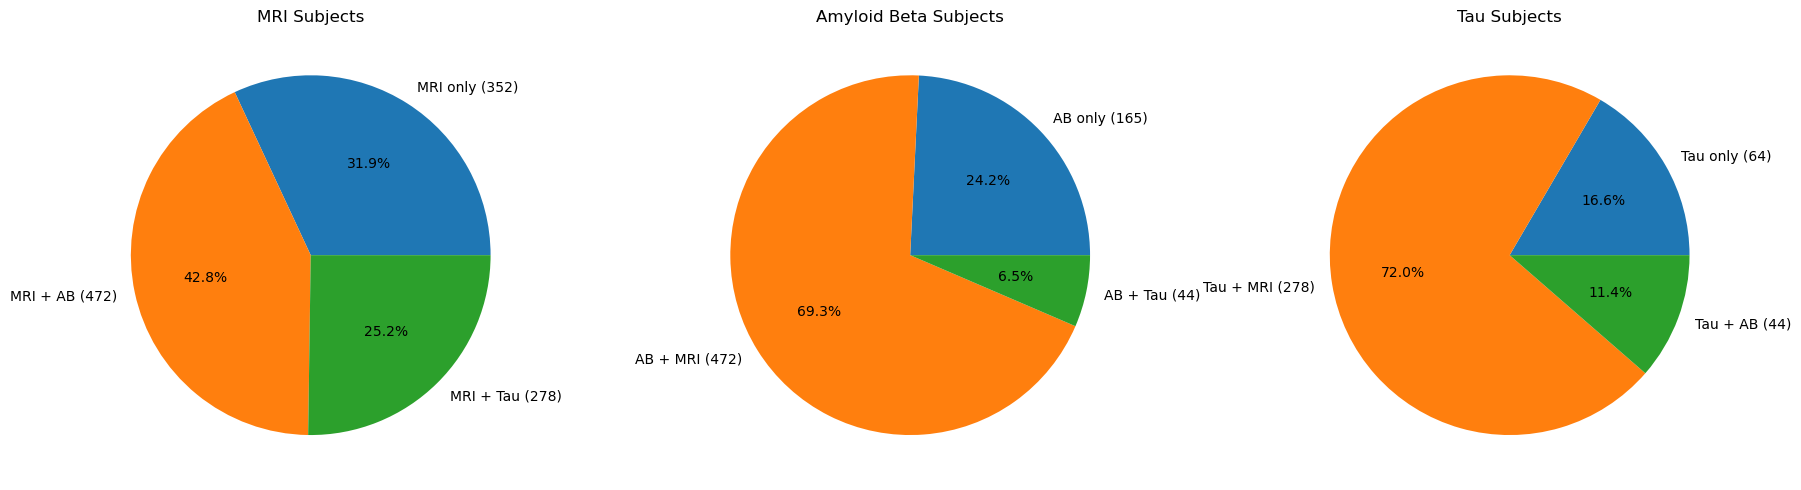

In [32]:
# Get unique RID sets from train datasets
mri_ids = set(mri_final['RID'])
ab_ids = set(ab_final['RID'])
tau_ids = set(tau_final['RID'])

# Function to compute exclusive and overlapping counts for a target set
def overlap_breakdown(target_ids, set1, set2):
    only = target_ids - set1 - set2
    with_1 = target_ids & set1 - set2
    with_2 = target_ids & set2 - set1
    return len(only), len(with_1), len(with_2)

# MRI-centric
mri_only, mri_ab, mri_tau = overlap_breakdown(mri_ids, ab_ids, tau_ids)
# AB-centric
ab_only, ab_mri, ab_tau = overlap_breakdown(ab_ids, mri_ids, tau_ids)
# Tau-centric
tau_only, tau_mri, tau_ab = overlap_breakdown(tau_ids, mri_ids, ab_ids)

# Pie plotting
def plot_pie(labels, sizes, title, ax):
    ax.pie(sizes, labels=[f"{l} ({s})" for l, s in zip(labels, sizes)], autopct='%1.1f%%')
    ax.set_title(title)

# Generate plots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
plot_pie(['MRI only', 'MRI + AB', 'MRI + Tau'], [mri_only, mri_ab, mri_tau], 'MRI Subjects', axes[0])
plot_pie(['AB only', 'AB + MRI', 'AB + Tau'], [ab_only, ab_mri, ab_tau], 'Amyloid Beta Subjects', axes[1])
plot_pie(['Tau only', 'Tau + MRI', 'Tau + AB'], [tau_only, tau_mri, tau_ab], 'Tau Subjects', axes[2])
plt.tight_layout()
plt.show()


In [34]:
# Combine all RIDs from the 8 dataframes
all_rids = set()

for df in [
    mri_final,
    ab_final,
    tau_final,
    multimodal_final,
    longitudinal_mri_final,
    longitudinal_ab_final,
    longitudinal_tau_final,
]:
    all_rids.update(df['RID'].unique())

print(f"Total unique RIDs across all datasets: {len(all_rids)}")


Total unique RIDs across all datasets: 1936


In [ ]:
modalities = {
    'AB': (ab_final),
    'TAU': (tau_final),
    'MRI': (mri_final)
}


# Variables to check 
vars_to_check = [age, mmse_score, retire_age, educ]

# Loop through each modality
for modality, (df) in modalities.items():
    print(f"\n📊 Missing/Zero Summary for {modality} Dataset:")
    total = len(df)
    
    for var in vars_to_check:
        if var not in df.columns:
            print(f"  ⚠️ Variable '{var}' not found in dataset.")
            continue

        missing_or_zero = df[var].isna() | (df[var] == 0)
        count = missing_or_zero.sum()
        percent = 100 * count / total

        print(f"  {var:<12}: {count:>4} missing/0 ({percent:>5.1f}%) of {total}")

In [ ]:
# Function to count missing/zero, but treat apoe4 zeros as valid
def missing_or_zero(series, var_name):
    if var_name == apoe4:
        # Only count missing (NaN), but NOT zeros
        return series.isna().sum()
    else:
        # Count missing or zero as invalid
        return ((series.isna()) | (series == 0)).sum()

# First group of datasets
dfs1 = [mri_final, ab_final, tau_final]
vars_to_check = [age, mmse_score, retire_age, educ, apoe4, dx, gender]

total_rows = 0
missing_zero_counts = {var: 0 for var in vars_to_check}
total_counts = {var: 0 for var in vars_to_check}

for df in dfs1:
    total_rows += len(df)
    for var in vars_to_check:
        if var in df.columns:
            missing_zero_counts[var] += missing_or_zero(df[var], var)
            total_counts[var] += len(df)

print(f"Total rows combined across all datasets (group 1): {total_rows}\n")
print("Missing/Zero counts and % across all rows of all datasets combined (group 1):\n")
for var in vars_to_check:
    if total_counts[var] > 0:
        percent = 100 * missing_zero_counts[var] / total_counts[var]
        print(f"{var:<12}: {missing_zero_counts[var]:>6} missing/0 out of {total_counts[var]:<6} rows ({percent:5.1f}%)")
    else:
        print(f"{var:<12}: variable not found in any dataset")

print("\n" + "="*60 + "\n")

# Second group of datasets
dfs2 = [multimodal_final, longitudinal_mri_final, longitudinal_ab_final, longitudinal_tau_final]

total_rows = 0
missing_zero_counts = {var: 0 for var in vars_to_check}
total_counts = {var: 0 for var in vars_to_check}

for df in dfs2:
    total_rows += len(df)
    for var in vars_to_check:
        if var in df.columns:
            missing_zero_counts[var] += missing_or_zero(df[var], var)
            total_counts[var] += len(df)

print(f"Total rows combined across all datasets (group 2): {total_rows}\n")
print("Missing/Zero counts and % across all rows of all datasets combined (group 2):\n")
for var in vars_to_check:
    if total_counts[var] > 0:
        percent = 100 * missing_zero_counts[var] / total_counts[var]
        print(f"{var:<12}: {missing_zero_counts[var]:>6} missing/0 out of {total_counts[var]:<6} rows ({percent:5.1f}%)")
    else:
        print(f"{var:<12}: variable not found in any dataset")


In [ ]:
def gender_counts(dfs, group_label):
    total_gender = Counter()

    for df in dfs:
        if 'PTGENDER' in df.columns:
            gender_data = df['PTGENDER'].dropna()
            total_gender.update(gender_data)

    print(f"\n Gender distribution in {group_label}:")
    for gender, count in total_gender.items():
        print(f"  {gender:<6}: {count} ({100 * count / sum(total_gender.values()):.1f}%)")

# Group 1 (Train)
dfs1 = [mri_final, ab_final, tau_final]
gender_counts(dfs1, "Train (Group 1)")

# Group 2 (Test)
dfs2 = [multimodal_final, longitudinal_mri_final, longitudinal_ab_final, longitudinal_tau_final]
gender_counts(dfs2, "Test (Group 2)")
